In [ ]:
# Import các thư viện và hàm cần thiết
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer,  KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **1. TỔNG QUAN**

In [ ]:
# Đoc file dữ liệu từ drive
data = pd.read_csv('/content/drive/My Drive/P28/Sample code/Datasample.csv')

# direction của TA -> Dùng lại thì mở link trên
#data = pd.read_csv('/content/drive/MyDrive/MCI Project/11. BlueInfo/Datasample.csv')
# Tạo 1 bản copy
df = data.copy()

In [ ]:
# Hiển thị 5 dòng đầu tiên
df.head(5)

,f1,f2,f3,f4,f5,f6,f7,f7.1,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,Customer_ID,y
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,361.0,1000001,Y
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,240.0,1000002,Y
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,1504.0,1000003,Y
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,1812.0,1000004,Y
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,434.0,1000005,Y


In [ ]:
# Hiển thị thông tin chung (tên cột, non-null count, dtype: định dạng dữ liệu)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   f1           99643 non-null   float64
 1   f2           99643 non-null   float64
 2   f3           99643 non-null   float64
 3   f4           99643 non-null   float64
 4   f5           99643 non-null   float64
 5   f6           99643 non-null   float64
 6   f7           99643 non-null   float64
 7   f7.1         99643 non-null   float64
 8   f8           99643 non-null   float64
 9   f9           99109 non-null   float64
 10  f10          99109 non-null   float64
 11  f11          100000 non-null  float64
 12  f12          100000 non-null  float64
 13  f13          100000 non-null  float64
 14  f14          100000 non-null  float64
 15  f15          100000 non-null  float64
 16  f16          100000 non-null  float64
 17  f17          100000 non-null  float64
 18  f18          100000 non-

> # *1.1. Phân tích và xử lí sơ bộ biến mục tiêu*

In [ ]:
# @title 1.1.1. Kiểm tra unique value
unique_values_tar = df['y'].unique()
print(f"Các giá trị duy nhất trong cột tar_column:\n{unique_values_tar}")

Các giá trị duy nhất trong cột tar_column:
['Y' 'N' nan]


In [ ]:
# @title 1.1.2. Biến đổi biến mục tiêu
# Chuyển đổi các giá trị của biến y thành 1 và 0
df['y'] = df['y'].replace({'Y': 1, 'N': 0})
# Đếm số lượng giá trị của cột mục tiêu sau biến đổi
count_values_after_transformation = df['y'].value_counts()
# Đếm tỷ lệ phần trăm của giá trị 1 và 0 trong cột 'Y' sau biến đổi
percentage_values_after_transformation = df['y'].value_counts(normalize=True) * 100

print(f"Số lượng giá trị của cột tar_column sau biến đổi:\n",count_values_after_transformation)
print(f"\nTỷ lệ phần trăm giá trị của cột tar_column sau biến đổi:\n",percentage_values_after_transformation)

Số lượng giá trị của cột tar_column sau biến đổi:
 1.0    67234
0.0    31034
Name: y, dtype: int64

Tỷ lệ phần trăm giá trị của cột tar_column sau biến đổi:
 1.0    68.419017
0.0    31.580983
Name: y, dtype: float64


In [ ]:
# @title 1.1.3. Xóa missing value
# In ra số lượng giá trị thiếu trong biến y
missing_values_y = df['y'].isnull().sum()
# Xóa các dòng có giá trị thiếu trong biến y
y_del_df = df.dropna(subset=["y"])

In [ ]:
# @title 1.1.4. Kết quả sau xử lí
# In ra số dòng của cột y
print(f"Số dòng của cột target column: {len(y_del_df['y'])}")

# In ra kiểu dữ liệu của cột y
print(f"Kiểu dữ liệu của cột target column: {y_del_df['y'].dtype}")

# In ra số lượng giá trị thiếu của cột y
missing_values_y = y_del_df['y'].isnull().sum()
print(f"Số lượng giá trị thiếu trong target column: {missing_values_y}")



Số dòng của cột target column: 98268
Kiểu dữ liệu của cột target column: float64
Số lượng giá trị thiếu trong target column: 0


 > # *1.2. Phân tích và xử lí sơ bộ biến đặc trưng*

In [ ]:
# Tính số lượng giá trị thiếu và giá trị duy nhất cho mỗi cột
missing_values = y_del_df.isnull().sum()
unique_values = y_del_df.nunique()

# Tính tỷ lệ giá trị thiếu và giá trị duy nhất
missing_percentage = (missing_values / y_del_df.shape[0] * 100).values
unique_percentage =  (unique_values / y_del_df.count() * 100).values

# Tạo DataFrame
uniq_miss_result_df = pd.DataFrame({'Cột': missing_values.index,
                          'Thiếu': missing_values.values,
                          '% Thiếu': missing_percentage,
                          'Số Unique': unique_values.values,
                          '% Unique': unique_percentage})

# Tính tỷ lệ phần trăm của giá trị duy nhất xuất hiện nhiều nhất trong mỗi cột
uniq_miss_result_df['% Unique Value Nhiều Nhất'] = [
    (y_del_df[col].value_counts().max() / y_del_df[col].count()) * 100 if not y_del_df[col].value_counts().empty else 0 for col in missing_values.index]

# Sắp xếp theo tỷ lệ giảm dần
uniq_miss_result_df = uniq_miss_result_df.sort_values(by='% Unique Value Nhiều Nhất', ascending=False)

# In ra DataFrame
print(uniq_miss_result_df.to_string(index=False))

        Cột  Thiếu   % Thiếu  Số Unique   % Unique  % Unique Value Nhiều Nhất
        f85  20347 20.705621          2   0.002567                  99.712529
        f46      0  0.000000         43   0.043758                  99.571580
        f20      0  0.000000         93   0.094639                  99.131966
        f14      0  0.000000         53   0.053934                  98.778850
        f12      0  0.000000         60   0.061058                  97.414214
        f80  31974 32.537550          2   0.003017                  96.968051
        f16      0  0.000000         50   0.050881                  96.889120
        f92      0  0.000000          2   0.002035                  95.917287
        f93      0  0.000000          2   0.002035                  95.221232
        f90      0  0.000000          2   0.002035                  94.202589
        f94      0  0.000000          2   0.002035                  91.784711
        f79      0  0.000000          2   0.002035              

In [ ]:
# @title 1.2.1. Kiểm tra duplicated column và row

# Kiểm tra sự giống nhau giữa các cặp cột
for i in range(y_del_df.shape[1]):
    for j in range(i+1, y_del_df.shape[1]):
        if df.iloc[:, i].equals(y_del_df.iloc[:, j]):
            print(f"Cột {y_del_df.columns[i]} giống hệt với cột {y_del_df.columns[j]}")
            break
else:
  print('Không có cột nào bị trùng lặp')

# Kiểm tra và so sánh các dòng trùng lặp
duplicated_rows = y_del_df[y_del_df.duplicated()]
if not duplicated_rows.empty:
    # Print the duplicated rows
    print("Các dòng bị trùng lặp:")
    print(duplicated_rows)
else:
    print("Không có dòng bị trùng lặp")

Không có cột nào bị trùng lặp
Không có dòng bị trùng lặp


In [ ]:
# @title 1.2.2. Hiển thị giá trị của cột kiểu object

# Lọc các cột có kiểu dữ liệu là object
object_columns = y_del_df.select_dtypes(include=['object']).columns

# In ra unique values trong các cột có kiểu dữ liệu là object
for column in object_columns:
    unique_values = y_del_df[column].unique()
    print(f"Unique values in {column} column: {unique_values}")

Unique values in f52 column: ['U' 'N' 'Y']
Unique values in f53 column: ['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'AA' 'U' 'Z' 'E' 'J' 'E4' 'W' 'DA' 'Y'
 'CC' 'GA' 'D4' 'D5' 'H' 'ZA' 'JF' 'K' 'B2' 'Z1' 'O' 'M' 'U1' 'Z4' 'A2'
 'V' 'I' 'TP' 'EM' 'C2' 'C5' 'Z5' 'D2' 'GY' 'ZY' 'E2' 'A3' 'V1' 'EF' 'Z2'
 'CY' 'EC' 'P1' 'IF' 'ZF' 'L']
Unique values in f54 column: ['N' 'Y']
Unique values in f70 column: ['S' 'U' 'T' 'C' nan 'R']
Unique values in f71 column: ['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'
 'NEW ENGLAND AREA' 'DALLAS AREA' 'CENTRAL/SOUTH TEXAS AREA'
 'TENNESSEE AREA' 'MIDWEST AREA' 'PHILADELPHIA AREA' 'OHIO AREA'
 'HOUSTON AREA' 'SOUTHWEST AREA' 'NEW YORK CITY AREA'
 'ATLANTIC SOUTH AREA' 'SOUTH FLORIDA AREA' 'CALIFORNIA NORTH AREA'
 'DC/MARYLAND/VIRGINIA AREA' 'NORTH FLORIDA AREA' nan 'LOS ANGELES AREA']
Unique values in f72 column: ['Y' 'N' 'T' 'U' nan]
Unique values in f73 column: ['N' 'R' nan]
Unique values in f77 column: ['WCMB' 'WC' nan 'UNKW']
Unique values in

In [ ]:
# Lưu số dòng trước khi xóa
rows_before = y_del_df.shape[0]
# Tạo một DataFrame để lưu thông tin về số dòng bị xóa cho từng cột
deleted_rows_info = pd.DataFrame(columns=['Cột', 'Số dòng bị xóa'])
# Chọn các cột có tỷ lệ giá trị thiếu dưới 1% hoặc trên 90%
selected_columns = y_del_df.columns[(missing_percentage < 1) | (missing_percentage > 90)]

# Tạo bản sao của DataFrame để tránh cảnh báo SettingWithCopyWarning
y_del_df_copy = y_del_df.copy()

# Xóa các dòng có giá trị thiếu trong các cột được chọn và lưu thông tin
for col in selected_columns:
    rows_deleted = y_del_df_copy[col].isnull().sum()
    deleted_rows_info = deleted_rows_info.append({'Cột': col, 'Số dòng bị xóa': rows_deleted}, ignore_index=True)

# Xóa các dòng có giá trị thiếu trong các cột được chọn trên bản sao của DataFrame
y_del_df_copy.dropna(subset=selected_columns, inplace=True)

# Lưu số dòng sau khi xóa
rows_after = y_del_df_copy.shape[0]

# Hiển thị thông tin về số dòng bị xóa cho từng cột
print("Thông tin về số dòng bị xóa cho từng cột:")
print(deleted_rows_info)

# Hiển thị tổng số dòng bị xóa
rows_deleted_total = rows_before - rows_after
print(f"\nTổng số dòng bị xóa: {rows_deleted_total}")


<ipython-input-16-861f4dd53c0f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_rows_info = deleted_rows_info.append({'Cột': col, 'Số dòng bị xóa': rows_deleted}, ignore_index=True)
<ipython-input-16-861f4dd53c0f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_rows_info = deleted_rows_info.append({'Cột': col, 'Số dòng bị xóa': rows_deleted}, ignore_index=True)
<ipython-input-16-861f4dd53c0f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_rows_info = deleted_rows_info.append({'Cột': col, 'Số dòng bị xóa': rows_deleted}, ignore_index=True)
<ipython-input-16-861f4dd53c0f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

Thông tin về số dòng bị xóa cho từng cột:
            Cột Số dòng bị xóa
0            f1            348
1            f2            348
2            f3            348
3            f4            348
4            f5            348
..          ...            ...
81          f95              0
82          f96              0
83          f97              1
84  Customer_ID              0
85            y              0

[86 rows x 2 columns]

Tổng số dòng bị xóa: 1734


In [ ]:
# @title 1.2.4. Loại bỏ sơ bộ unique value
# Loại bỏ các cột có rất ít unique value và có unique value chiếm nhiều nhất từ 90% trở lên
# Lọc các cột theo điều kiện
filtered_columns = uniq_miss_result_df[(uniq_miss_result_df['% Unique Value Nhiều Nhất'] > 90)
                          & (uniq_miss_result_df['% Unique'] <= 1.0) & (uniq_miss_result_df['% Thiếu'] <= 1.0) ]
# In ra DataFrame sau khi lọc
print("Các cột cần loại bỏ:")
print(filtered_columns.to_string(index=False))
# Loại bỏ các cột
columns_to_remove = filtered_columns['Cột'].tolist()
uniq_del_df = y_del_df.drop(columns=columns_to_remove, axis=1)

Các cột cần loại bỏ:
Cột  Thiếu  % Thiếu  Số Unique  % Unique  % Unique Value Nhiều Nhất
f46      0      0.0         43  0.043758                  99.571580
f20      0      0.0         93  0.094639                  99.131966
f14      0      0.0         53  0.053934                  98.778850
f12      0      0.0         60  0.061058                  97.414214
f16      0      0.0         50  0.050881                  96.889120
f92      0      0.0          2  0.002035                  95.917287
f93      0      0.0          2  0.002035                  95.221232
f90      0      0.0          2  0.002035                  94.202589
f94      0      0.0          2  0.002035                  91.784711
f79      0      0.0          2  0.002035                  91.741971
f36      0      0.0        233  0.237107                  91.061180
f95      0      0.0          2  0.002035                  91.030651
f40      0      0.0        253  0.257459                  90.432287


> # *1.3. Output sau khi clean*

In [ ]:
# Tính số lượng giá trị thiếu và giá trị duy nhất cho mỗi cột
missing_values = uniq_del_df.isnull().sum()
unique_values = uniq_del_df.nunique()

# Tính tỷ lệ giá trị thiếu và giá trị duy nhất
missing_percentage = (missing_values / uniq_del_df.count() * 100).values
unique_percentage =  (unique_values / uniq_del_df.count() * 100).values

# Tạo DataFrame
uniq_miss_result_2_df = pd.DataFrame({'Cột': missing_values.index,
                          'Thiếu': missing_values.values,
                          '% Thiếu': missing_percentage,
                          'Số Unique': unique_values.values,
                          '% Unique': unique_percentage})

# Tính tỷ lệ phần trăm của giá trị duy nhất xuất hiện nhiều nhất trong mỗi cột
uniq_miss_result_2_df['% Unique Value Nhiều Nhất'] = [
    (uniq_del_df[col].value_counts().max() / uniq_del_df[col].count()) * 100 if not uniq_del_df[col].value_counts().empty else 0 for col in missing_values.index]

# Sắp xếp theo tỷ lệ giảm dần
uniq_miss_result_2_df = uniq_miss_result_2_df.sort_values(by='% Unique Value Nhiều Nhất', ascending=False)

# In ra DataFrame
print(uniq_miss_result_2_df.to_string(index=False))

        Cột  Thiếu   % Thiếu  Số Unique   % Unique  % Unique Value Nhiều Nhất
        f85  20347 26.112345          2   0.002567                  99.712529
        f80  31974 48.230609          2   0.003017                  96.968051
        f38      0  0.000000       3125   3.180079                  91.063215
        f42      0  0.000000       3493   3.554565                  90.420076
        f96      0  0.000000          2   0.002035                  89.860382
        f29      0  0.000000       4357   4.433793                  86.634510
        f22      0  0.000000        361   0.367363                  86.634510
       f7.1    348  0.355392        769   0.785335                  86.295956
        f54      0  0.000000          2   0.002035                  86.257988
        f73      1  0.001018          2   0.002035                  85.570944
        f18      0  0.000000        381   0.387715                  85.052102
        f77  10053 11.396021          3   0.003401              

In [ ]:
# In ra kết quả sau bước data cleaning
uniq_del_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98268 entries, 0 to 99999
Data columns (total 87 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   f1           97920 non-null  float64
 1   f2           97920 non-null  float64
 2   f3           97920 non-null  float64
 3   f4           97920 non-null  float64
 4   f5           97920 non-null  float64
 5   f6           97920 non-null  float64
 6   f7           97920 non-null  float64
 7   f7.1         97920 non-null  float64
 8   f8           97920 non-null  float64
 9   f9           97392 non-null  float64
 10  f10          97392 non-null  float64
 11  f11          98268 non-null  float64
 12  f13          98268 non-null  float64
 13  f15          98268 non-null  float64
 14  f17          98268 non-null  float64
 15  f18          98268 non-null  float64
 16  f19          98268 non-null  float64
 17  f21          98268 non-null  float64
 18  f22          98268 non-null  float64
 19  f23 

Số cột còn lại: 87 cột (71 cột số, 16 cột object)

Số dòng còn lại: 98,268

# **2. DATA PREPROCESSING VÀ EDA**

In [ ]:
# Sao chép DataFrame đã clean ở phần 1
cleaned_df = uniq_del_df.copy()

> # *2.1. Tách thành feature và label df*

In [ ]:
# Tách cột y và features (X) sang hai df khác nhau
df_features = cleaned_df.drop(columns=['y'])  # DataFrame chứa các feature
df_labels = cleaned_df['y']  # DataFrame chứa label
# In ra một số dòng đầu của df_features và df_labels
print("DataFrame chứa các tính năng:")
print(df_features.head(5))
print("\nDataFrame chứa nhãn:")
print(df_labels.head(5))

DataFrame chứa các tính năng:
        f1      f2      f3      f4     f5   f6   f7  f7.1   f8      f9  ...  \
0  23.9975  219.25  22.500  0.2475   0.00  0.0  0.0   0.0  0.0 -157.25  ...   
1  57.4925  482.75  37.425  0.2475  22.75  9.1  9.1   0.0  0.0  532.25  ...   
2  16.9900   10.25  16.990  0.0000   0.00  0.0  0.0   0.0  0.0   -4.25  ...   
3  38.0000    7.50  38.000  0.0000   0.00  0.0  0.0   0.0  0.0   -1.50  ...   
4  55.2300  570.50  71.980  0.0000   0.00  0.0  0.0   0.0  0.0   38.50  ...   

   f84  f85  f86  f87  f88  f89  f91  f96     f97  Customer_ID  
0  1.0    M  4.0  3.0    C    A    N    U   361.0      1000001  
1  1.0    M  5.0  1.0    C    A    Z    U   240.0      1000002  
2  2.0    M  5.0  2.0    C    A    N    U  1504.0      1000003  
3  4.0    M  6.0  1.0    C    D    U    U  1812.0      1000004  
4  1.0    M  6.0  1.0    C    O    I    U   434.0      1000005  

[5 rows x 86 columns]

DataFrame chứa nhãn:
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype:

In [ ]:
# Lấy danh sách các cột có kiểu dữ liệu int
int_columns = df_features.select_dtypes(include='int').columns

# Ép kiểu các cột từ int sang float
df_features[int_columns] = df_features[int_columns].astype(float)

# Kiểm tra lại kiểu dữ liệu sau khi ép kiểu
print(df_features.dtypes)

f1             float64
f2             float64
f3             float64
f4             float64
f5             float64
                ...   
f89             object
f91             object
f96             object
f97            float64
Customer_ID    float64
Length: 86, dtype: object


> # *2.3. Chia dữ liệu*

In [ ]:
# @title 2.3.1. Tách thành tập train, test
# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42)
# In ra số lượng giá trị mỗi tập
print(f"Số lượng mẫu trong tập huấn luyện:\n {len(X_train)}")
print(f"Số lượng mẫu trong tập kiểm tra:\n {len(X_test)}")
# In ra số lượng giá trị trong từng tập
print("y_train:\n",y_train.value_counts())
print("y_test:\n",y_test.value_counts())


Số lượng mẫu trong tập huấn luyện:
 78614
Số lượng mẫu trong tập kiểm tra:
 19654
y_train:
 1.0    53783
0.0    24831
Name: y, dtype: int64
y_test:
 1.0    13451
0.0     6203
Name: y, dtype: int64


Các cột vẫn giữ nguyên dtype, có 70 cột float và 16 cột object

In [ ]:
# @title 2.3.2. Thống kê cơ bản
X_train.describe()

,f1,f2,f3,f4,f5,f6,f7,f7.1,f8,f9,...,f74,f75,f76,f78,f81,f84,f86,f87,f97,Customer_ID
count,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,78330.000000,77907.000000,...,77940.000000,78613.000000,78613.000000,78614.000000,55868.000000,61618.000000,59653.000000,40574.000000,78613.000000,7.861400e+04
mean,58.539584,511.735357,46.087787,0.888335,40.796637,13.486311,13.226426,0.257200,1.286528,-14.102272,...,101.579547,1.788190,1.546475,0.189114,6.185509,2.534454,5.783313,1.566545,392.942732,1.049859e+06
std,46.901116,525.722948,23.625412,2.205616,97.894565,30.647405,30.222290,2.804803,16.161887,279.860099,...,60.941535,1.323429,0.901890,0.391602,4.738455,1.454055,2.176309,0.625572,256.785525,2.883659e+04
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,9.989998,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-5.000000,1.000001e+06
25%,33.240000,149.750000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-86.250000,...,29.989990,1.000000,1.000000,0.000000,2.000000,1.000000,4.000000,1.000000,212.000000,1.024927e+06
50%,48.002500,354.500000,44.990000,0.247500,2.750000,1.000000,0.675000,0.000000,0.000000,-6.250000,...,99.989990,1.000000,1.000000,0.000000,5.000000,2.000000,6.000000,1.000000,342.000000,1.049784e+06
75%,70.460000,699.000000,59.990000,0.742500,41.750000,14.316250,13.912500,0.000000,0.235000,62.250000,...,149.989990,2.000000,2.000000,0.000000,9.000000,3.000000,7.000000,2.000000,532.000000,1.074778e+06
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,1102.400000,890.762500,294.800000,3685.200000,31219.250000,...,499.989990,28.000000,16.000000,1.000000,15.000000,6.000000,9.000000,3.000000,1813.000000,1.099999e+06


> # *2.4. Xử lí missing data*

In [ ]:
def handle_missing_values(df):
    # Xử lí missing values cho numerical columns
    numerical_cols = df.select_dtypes(include='number').columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

    # Xử lí missing values cho categorical columns
    categorical_cols = df.select_dtypes(include='object').columns
    for col in categorical_cols:
        # Tính tỉ lệ missing values
        missing_ratio = df[col].isnull().mean()

        if missing_ratio < 0.05:
            # Thay thế bằng mode nếu tỉ lệ missing dưới 5%
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
        else:
            # Thay thế bằng "missing" nếu tỉ lệ missing trên 5%
            df[col] = df[col].fillna("missing")

    return df
# Gọi hàm xử lí missing value chỉ cho tập X_train
X_train_missing_handled = handle_missing_values(X_train)

# Kiểm tra lại số lượng missing value sau khi xử lý
missing_values_count_train = X_train_missing_handled.isnull().sum()
# Hiển thị số lượng missing value sau khi xử lý
print("Missing Values Count After Processing - Training Set:")
print(missing_values_count_train)
# In ra số lượng giá trị trong tập X_train
print("X_train:", X_train_missing_handled.value_counts())

Missing Values Count After Processing - Training Set:
f1             0
f2             0
f3             0
f4             0
f5             0
              ..
f89            0
f91            0
f96            0
f97            0
Customer_ID    0
Length: 86, dtype: int64
X_train: f1          f2        f3        f4      f5     f6       f7       f7.1   f8       f9         f10         f11        f13        f15         f17         f18       f19        f21         f22       f23       f24       f25       f26        f27       f28         f29   f30         f31        f32        f33        f34        f35         f37         f38   f39         f41         f42  f43        f44         f45         f47       f48  f49   f50  f51  f52  f53  f54  f55     f56      f57      f58      f59      f60     f61     f62      f63     f64     f65    f66    f67     f68    f69    f70      f71                        f72  f73  f74         f75  f76  f77      f78  f80      f81  f82      f83  f84  f85      f86  f87  f88      f89

In [ ]:
X_train_missing_handled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78614 entries, 16304 to 16043
Data columns (total 86 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   f1           78614 non-null  float64
 1   f2           78614 non-null  float64
 2   f3           78614 non-null  float64
 3   f4           78614 non-null  float64
 4   f5           78614 non-null  float64
 5   f6           78614 non-null  float64
 6   f7           78614 non-null  float64
 7   f7.1         78614 non-null  float64
 8   f8           78614 non-null  float64
 9   f9           78614 non-null  float64
 10  f10          78614 non-null  float64
 11  f11          78614 non-null  float64
 12  f13          78614 non-null  float64
 13  f15          78614 non-null  float64
 14  f17          78614 non-null  float64
 15  f18          78614 non-null  float64
 16  f19          78614 non-null  float64
 17  f21          78614 non-null  float64
 18  f22          78614 non-null  float64
 19  

In [ ]:
X_train_missing_handled.head(5)

,f1,f2,f3,f4,f5,f6,f7,f7.1,f8,f9,...,f84,f85,f86,f87,f88,f89,f91,f96,f97,Customer_ID
16304,33.7575,112.25,29.99,0.7425,6.50,2.275,2.275,0.000,0.4800,16.75,...,5.0,M,9.0,3.0,C,A,N,U,724.0,1016305.0
49404,96.3650,1276.50,84.99,4.9500,16.50,6.435,0.000,6.435,6.7400,-198.50,...,2.0,M,1.0,1.0,A,F,U,U,22.0,1049405.0
97455,102.2900,780.25,69.99,0.0000,85.75,34.300,34.300,0.000,0.0000,475.75,...,2.0,missing,6.0,1.0,missing,missing,N,U,20.0,1097456.0
16711,80.3325,601.25,50.00,0.4950,107.25,32.175,32.175,0.000,1.0375,-589.25,...,5.0,M,7.0,3.0,missing,A,U,U,206.0,1016712.0
71952,30.2600,291.50,39.99,0.0000,0.00,0.000,0.000,0.000,0.0000,-137.50,...,1.0,M,9.0,1.0,C,B,O,U,23.0,1071953.0


In [ ]:
# Transform cho X_test
# Sử dụng hàm handle_missing_values để xử lý missing values cho X_test
X_test_missing_handled = handle_missing_values(X_test)

# Kiểm tra kết quả
print(X_test_missing_handled.head(5))
print(X_test_missing_handled.info())


             f1       f2     f3     f4     f5       f6       f7  f7.1     f8  \
85459   78.9800  1709.50  59.99  2.475  49.25  19.7000  19.7000   0.0  6.815   
32180   35.6875   284.25  30.00  0.000  16.25   5.6875   5.6875   0.0  0.000   
98285  112.9475   421.50  99.99  0.000   0.00   0.0000   0.0000   0.0  0.000   
1377    34.3875   137.75  35.00  0.000   0.00   0.0000   0.0000   0.0  0.000   
35966   47.0150   240.50  39.99  0.000  18.75   6.5625   6.5625   0.0  0.000   

           f9  ...  f84      f85  f86  f87      f88      f89  f91  f96    f97  \
85459  -19.50  ...  2.0  missing  6.0  1.0  missing  missing    H    U  230.0   
32180  -54.25  ...  3.0        M  4.0  1.0        C        N    N    U  734.0   
98285 -366.50  ...  4.0        M  6.0  1.0        C        A    H    U  541.0   
1377   -68.75  ...  2.0        M  9.0  2.0        C        A    U    U  629.0   
35966 -214.50  ...  3.0        M  6.0  2.0        B        A    N    U  530.0   

       Customer_ID  
85459    10

> # *2.5. Ma trận tương quan và biểu đồ phân phối*

<ipython-input-32-52bb615ff4c1>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_test_missing_handled.corr()


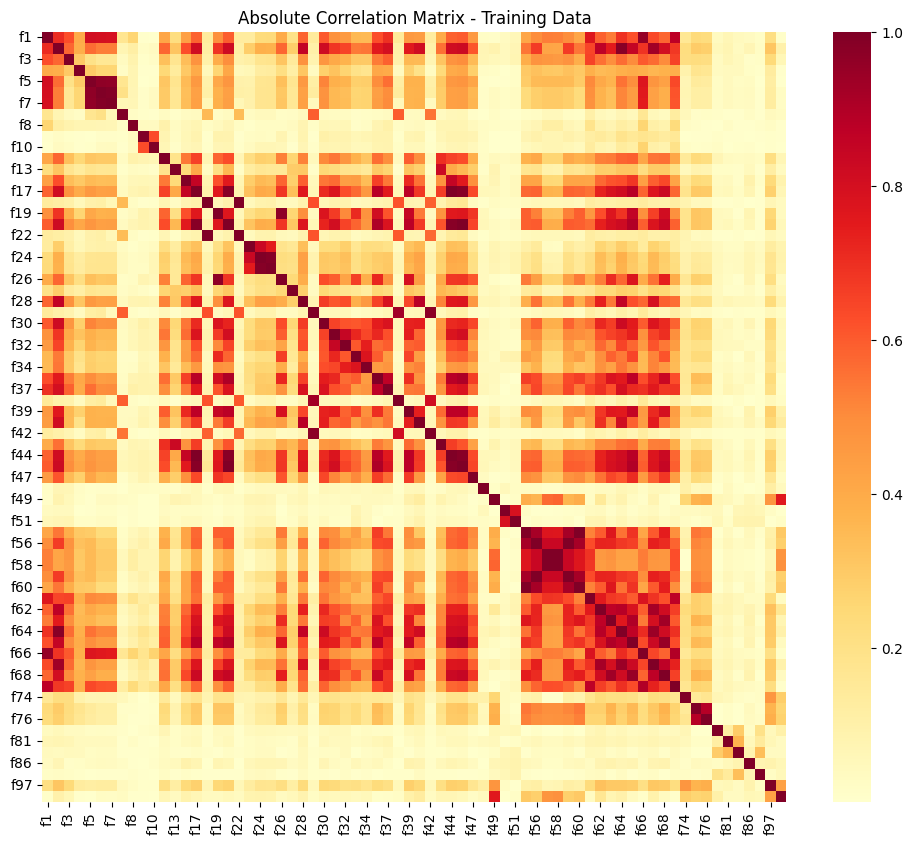

In [ ]:
# @title 2.5.1. Biểu diễn ma trận tương quan
# Tính toán correlation matrix
correlation_matrix = X_test_missing_handled.corr()

# Lấy giá trị tuyệt đối của từng phần tử trong ma trận
absolute_correlation_matrix = np.abs(correlation_matrix)

# Vẽ heatmap của absolute correlation matrix với màu 'RdYlBu'
plt.figure(figsize=(12, 10))
sns.heatmap(absolute_correlation_matrix, annot=False, cmap="YlOrRd", fmt=".2f")
plt.title("Absolute Correlation Matrix - Training Data")
plt.show()

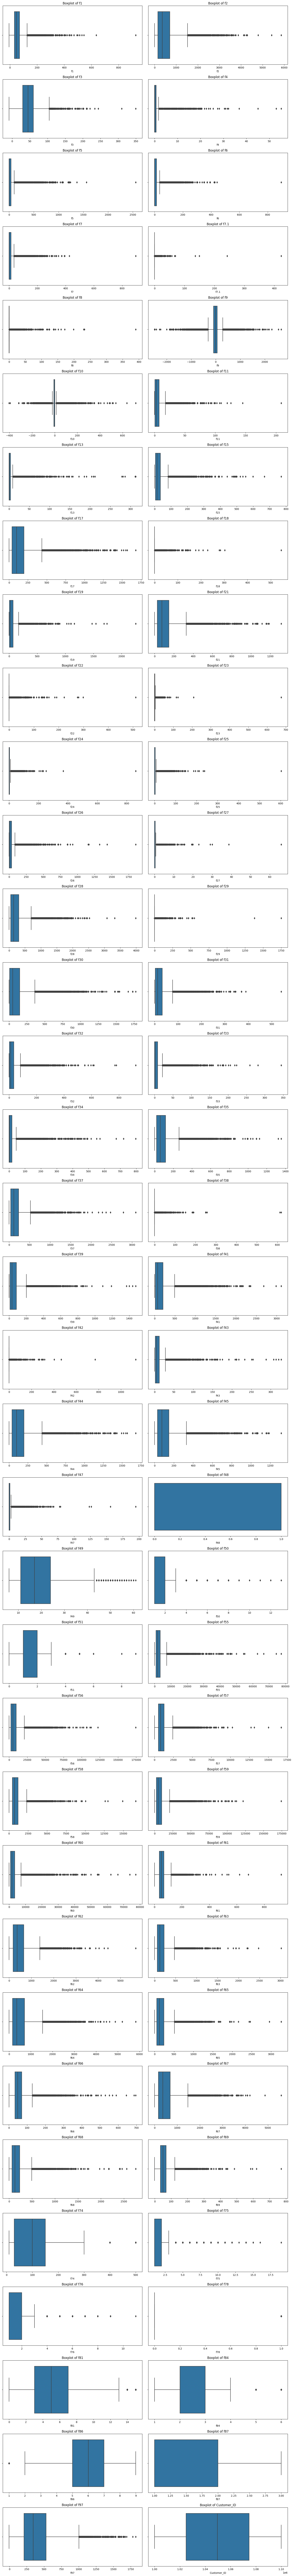

In [ ]:
# @title 2.5.2. Biểu đồ box plot phân phối của các cột numeric
# Chọn những cột có kiểu dữ liệu là số (numeric)
numeric_columns = X_test_missing_handled.select_dtypes(include=[np.number]).columns

# Tính toán số lượng cột và dòng cho subplot
n_columns = len(numeric_columns)
n_rows = (n_columns // 2) + (n_columns % 2)

# Set kích thước của plot
plt.figure(figsize=(16, 4 * n_rows))

# Lặp qua từng cột số
for i, column in enumerate(numeric_columns):
    # Tạo subplot cho mỗi cột
    plt.subplot(n_rows, 2, i+1)

    # Vẽ boxplot cho cột hiện tại
    sns.boxplot(x=X_test_missing_handled[column])
    plt.title(f'Boxplot of {column}')

# Điều chỉnh layout cho không gian tốt hơn
plt.tight_layout()

# Hiển thị boxplots
plt.show()

> # *2.6*. *WoE*

In [ ]:
X_train_missing_handled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train_df = pd.concat([X_train_missing_handled, y_train], axis=1)

In [ ]:
# Lọc ra các cột numeric và cột 'y' từ DataFrame hiện tại (train_df)
numeric_target_df = train_df.loc[:, train_df.select_dtypes(include=[np.number]).columns.union(['y'])].drop(columns=['Customer_ID'])
# Lọc ra các cột categorical và cột 'y' từ DataFrame hiện tại (train_df)
categorical_target_df = train_df.loc[:, train_df.select_dtypes(include=['object']).columns.union(['y'])]

In [ ]:
# Thêm thông tin về missing values, số lượng giá trị, định dạng và số lượng cột cho numeric_target_df
numeric_info = pd.DataFrame({
    'Column': numeric_target_df.columns,
    'Missing Values': numeric_target_df.isna().sum(),
    'Value Counts': numeric_target_df.count(),
    'Data Type': numeric_target_df.dtypes
})

# Hiển thị thông tin cho numeric_target_df
print("Numeric Target DataFrame Information:")
print(numeric_info.to_string())

Numeric Target DataFrame Information:
     Column  Missing Values  Value Counts Data Type
f1       f1               0         78614   float64
f10     f10               0         78614   float64
f11     f11               0         78614   float64
f13     f13               0         78614   float64
f15     f15               0         78614   float64
f17     f17               0         78614   float64
f18     f18               0         78614   float64
f19     f19               0         78614   float64
f2       f2               0         78614   float64
f21     f21               0         78614   float64
f22     f22               0         78614   float64
f23     f23               0         78614   float64
f24     f24               0         78614   float64
f25     f25               0         78614   float64
f26     f26               0         78614   float64
f27     f27               0         78614   float64
f28     f28               0         78614   float64
f29     f29               

In [ ]:
# Thêm thông tin về missing values, số lượng giá trị, định dạng và số lượng cột cho categorical_target_df
categorical_info = pd.DataFrame({
    'Column': categorical_target_df.columns,
    'Missing Values': categorical_target_df.isna().sum(),
    'Value Counts': categorical_target_df.count(),
    'Data Type': categorical_target_df.dtypes
})

# Hiển thị thông tin cho categorical_target_df
print("\nCategorical Target DataFrame Information:")
print(categorical_info.to_string())


Categorical Target DataFrame Information:
    Column  Missing Values  Value Counts Data Type
f52    f52               0         78614    object
f53    f53               0         78614    object
f54    f54               0         78614    object
f70    f70               0         78614    object
f71    f71               0         78614    object
f72    f72               0         78614    object
f73    f73               0         78614    object
f77    f77               0         78614    object
f80    f80               0         78614    object
f82    f82               0         78614    object
f83    f83               0         78614    object
f85    f85               0         78614    object
f88    f88               0         78614    object
f89    f89               0         78614    object
f91    f91               0         78614    object
f96    f96               0         78614    object
y        y               0         78614   float64


Event là y=0

Non-event là y = 1

> ## 2.6.1. WoE cho numeric

In [ ]:
from tabulate import tabulate
def iv_woe_all_vars(data, target, iv_bins, iv_threshold, show_woe=True):
    iv_results = pd.DataFrame(columns=["Variable", "IV"])
    independent_vars = data.columns.difference([target])

    for ivars in independent_vars:
        d0 = data[[ivars, target]].copy()

        bins = pd.qcut(data[ivars], q=iv_bins, duplicates='drop')
        d0['bin'] = bins
        grouped = d0.groupby('bin', as_index=False)
        d = pd.DataFrame(grouped[target].agg(['count', 'sum', 'mean']))
        d.columns = ['Count', 'Non-Events', 'Non-Event Rate']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Event Rate'] / d['Non-Event Rate'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d['IV'] = (d['Non-Event Rate'] - d['Event Rate']) * d['WOE']
        iv_value = d['IV'].sum()

        if show_woe:
            print("WOE and IV for", ivars)
            print(tabulate(d, headers='keys', tablefmt='pretty'))

        iv_results = pd.concat([iv_results, pd.DataFrame({"Variable": [ivars], "IV": [iv_value]})], ignore_index=True)

    iv_results = iv_results.sort_values(by='IV', ascending=False)
    selected_features = iv_results[iv_results['IV'] > iv_threshold]['Variable'].tolist()

    return iv_results, selected_features

# Áp dụng hàm iv_woe_all_vars cho tất cả các biến trong tập train_df
iv_results_num, selected_features_num = iv_woe_all_vars(numeric_target_df, target='y', iv_bins=20, iv_threshold=0.1, show_woe=True)

# Hiển thị kết quả IV và danh sách các tính năng được chọn
print("Information Value Results:")
print(tabulate(iv_results_num, headers='keys', tablefmt='pretty'))  # Use tabulate for better formatting

WOE and IV for f1
+-----------------------------+--------+------------+----------------------+--------+----------------------+-----------------------+------------------------+
|             bin             | Count  | Non-Events |    Non-Event Rate    | Events |      Event Rate      |          WOE          |           IV           |
+-----------------------------+--------+------------+----------------------+--------+----------------------+-----------------------+------------------------+
| (-6.1690000000000005, 15.0] | 3941.0 |   2919.0   | 0.054122677423003876 | 1022.0 | 0.04115822963231445  |  0.27382937585637696  |  0.003550046646847071  |
|       (15.0, 25.002]        | 3921.0 |   3012.0   | 0.05613189936260532  | 909.0  | 0.03660746647335991  |  0.42745204541088955  |  0.008345758773995593  |
|       (25.002, 30.0]        | 4424.0 |   3367.0   | 0.05561342096265412  | 1057.0 | 0.04256775804438001  |  0.2673274430495816   | 0.0034874637108289605  |
|       (30.0, 30.822]        | 34

Có 2 cột có IV = 0 -> Kiểm tra các cột này để xem xét các giá trị và tương quan với y

Có 23 cột có IV < 0.1 => loại bỏ

In [ ]:
def print_column_info(df, column):
    count_unique = df[column].nunique()
    print(f"Number of unique values in {column}: {count_unique}")
    print(f"Value counts for {column}:\n{df[column].value_counts()}")
    correlation = df[column].corr(df['y'])
    print(f"Correlation between {column} and y: {correlation}\n")

# In thông tin cho từng cột
columns_to_check = ['f48', 'f78']
for column in columns_to_check:
    print_column_info(numeric_target_df, column)

Number of unique values in f48: 2
Value counts for f48:
0.0    39673
1.0    38941
Name: f48, dtype: int64
Correlation between f48 and y: -0.015768105378746237

Number of unique values in f78: 2
Value counts for f78:
0.0    63747
1.0    14867
Name: f78, dtype: int64
Correlation between f78 and y: 0.25253020149586847



Có thể thấy giá trị IV của f48 và f78 = 0 do hai cột này chỉ có hai giá trị duy nhất (0/1)

Value của f48 có tỉ lệ 0 và 1 xấp xỉ nhau

Value của f78 có tỉ lệ 0 cao hơn hẳn so với tỉ lệ 1

Tương quan giữa 2 cột này với giá trị ở cột target là tương đối yếu (xấp xỉ 0-0.2)

=> đề xuất loại bỏ

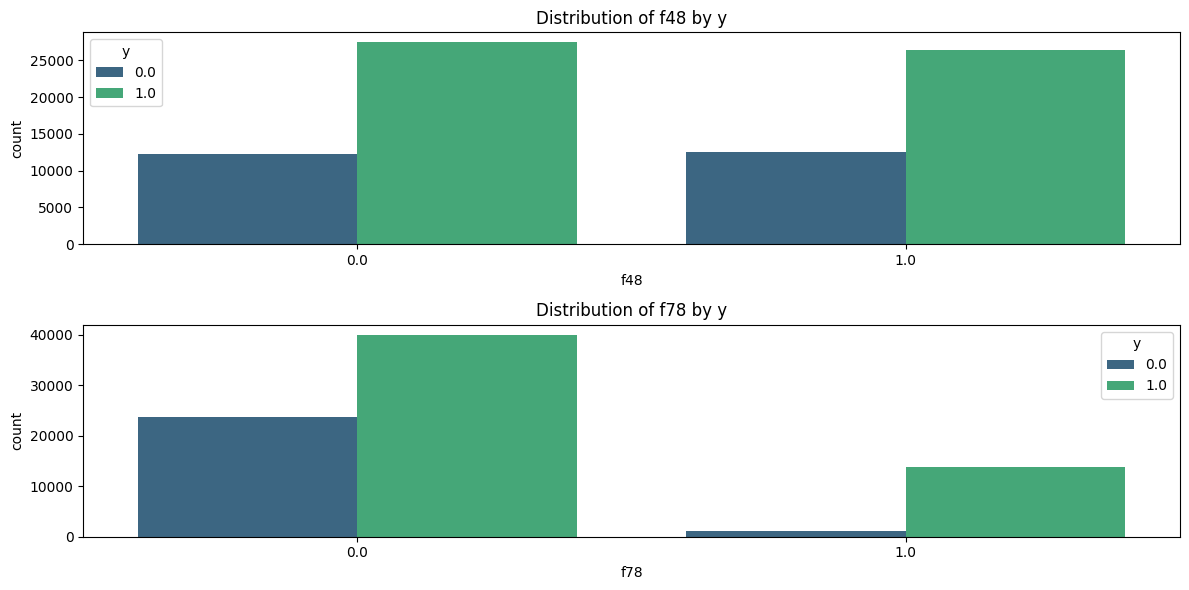

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ cột nhóm cho f48 và f78
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
sns.countplot(x='f48', hue='y', data=train_df, palette='viridis')
plt.title('Distribution of f48 by y')

plt.subplot(2, 1, 2)
sns.countplot(x='f78', hue='y', data=train_df, palette='viridis')
plt.title('Distribution of f78 by y')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_trend(data, variable, target, iv_bins):
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins = pd.qcut(data[variable], q=iv_bins, duplicates='drop')
        data['bin'] = bins
        grouped = data.groupby('bin', as_index=False)
        d = pd.DataFrame(grouped[target].agg(['count', 'sum']))
        d.columns = ['Count', 'Non-Events']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        bin_labels = [str(bin) for bin in sorted(data['bin'].unique())]
        bin_midpoints = np.arange(len(bin_labels))
        bar_width = 0.35
    else:
        d = pd.DataFrame(data.groupby(variable, as_index=False).agg({target: ['count', 'sum']}))
        d.columns = ['Variable', 'Count', 'Non-Events']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        bin_labels = [str(bin) for bin in sorted(data[variable].unique())]
        bin_midpoints = np.arange(len(bin_labels))
        bar_width = 0.35

    # Create a figure and axis for WOE
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the WOE trend
    ax1.plot(bin_midpoints, d['WOE'], marker='o', color='b', label='WOE')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('WOE', color='b')
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels(bin_labels, rotation='vertical')
    ax1.tick_params('y', colors='b')

    # Create a secondary axis for Count of Events and Non-Events
    ax2 = ax1.twinx()

    # Plot the event and non-event trends side by side with different colors and labels
    ax2.bar(bin_midpoints - bar_width/2, d['Events'], label='y=0 (Event)', width=bar_width, alpha=0.7, color='orange')
    ax2.bar(bin_midpoints + bar_width/2, d['Non-Events'], label='y=1 (Non-Event)', width=bar_width, alpha=0.7, color='green')
    ax2.set_ylabel('Count', color='r')
    ax2.tick_params('y', colors='r')

    fig.suptitle(f'Trend for {variable}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.8, 0.8))

    plt.show()

# Plot the combined trends for all numeric features
for feature in numeric_target_df.columns:
    if feature != 'y':  # Skip the target variable
        plot_combined_trend(numeric_target_df, feature, 'y', iv_bins=20)


In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def iv_woe_all_vars(data, target, iv_bins, iv_threshold, show_woe=True, woe_diff_threshold=0.5):
    iv_results = pd.DataFrame(columns=["Variable", "IV"])
    independent_vars = data.columns.difference([target])

    for ivars in independent_vars:
        d0 = data[[ivars, target]].copy()

        bins = pd.qcut(data[ivars], q=iv_bins, duplicates='drop')
        d0['bin'] = bins
        d0['new_bin'] = d0['bin']

        # Tìm và gộp các đoạn chênh lệch
        chenh_lech_index = d0.groupby('new_bin')['WOE'].diff().abs() > woe_diff_threshold
        d0['new_bin'] = np.where(chenh_lech_index, d0['new_bin'] + '_merged', d0['new_bin'])

        # Tính lại WOE và IV sau khi gộp
        grouped_merged = d0.groupby('new_bin', as_index=False)
        d = pd.DataFrame(grouped_merged[target].agg(['count', 'sum', 'mean']))
        d.columns = ['Count', 'Non-Events', 'Non-Event Rate']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Event Rate'] / d['Non-Event Rate'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d['IV'] = (d['Non-Event Rate'] - d['Event Rate']) * d['WOE']

        if show_woe:
            print("WOE and IV for", ivars)
            print(tabulate(d, headers='keys', tablefmt='pretty'))

        # Lưu ý về bin mới và tính lại IV
        bins_after_merge = d['new_bin'].unique()
        d0['bin'] = pd.Categorical(d0['new_bin'], categories=bins_after_merge)
        iv_value = d['IV'].sum()

        iv_results = pd.concat([iv_results, pd.DataFrame({"Variable": [ivars], "IV": [iv_value]})], ignore_index=True)

    iv_results = iv_results.sort_values(by='IV', ascending=False)
    selected_features = iv_results[iv_results['IV'] > iv_threshold]['Variable'].tolist()

    return iv_results, selected_features

# Áp dụng hàm iv_woe_all_vars cho tất cả các biến trong tập train_df
iv_results_num, selected_features_num = iv_woe_all_vars(numeric_target_df, target='y', iv_bins=20, iv_threshold=0.1, show_woe=True)

# Hiển thị kết quả IV và danh sách các tính năng được chọn
print("Information Value Results:")
print(tabulate(iv_results_num, headers='keys', tablefmt='pretty'))  # Use tabulate for better formatting


KeyError: ignored

In [ ]:
# Extract 'y' column and selected features from numeric_target_df
selected_columns = ['y'] + selected_features_num
numeric_target_df = numeric_target_df[selected_columns]
# Create a separate WoE mapping dictionary for columns with IV > 0.1
woe_mapping_num = {}

for ivars in selected_features_num:
    d0 = numeric_target_df[[ivars, 'y']].copy()

    bins = pd.qcut(numeric_target_df[ivars], q=30, duplicates='drop')
    grouped = d0.groupby(bins, as_index=False)
    d = pd.DataFrame(grouped['y'].agg(['count', 'sum', 'mean']))
    d.columns = ['Count', 'Non-Events', 'Non-Event Rate']
    d['Events'] = d['Count'] - d['Non-Events']
    d['Event Rate'] = d['Events'] / d['Events'].sum()
    d['Non-Event Rate'] = d['Non-Event Rate'] / d['Non-Event Rate'].sum()
    d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])

    # Use the index directly for mapping
    woe_mapping_num[ivars] = dict(zip(d.index, d['WOE']))

    # Map WoE values to the original DataFrame only for selected features
    numeric_target_df[ivars] = numeric_target_df[ivars].map(woe_mapping_num[ivars])

# Handle missing values using backfill (bfill) only for missing values in each column
numeric_target_df = numeric_target_df.apply(lambda x: x.fillna(method='bfill'))

# Display the WoE mapping dictionary
print("WoE Mapping Dictionary:")
print(woe_mapping_num)

# Display the DataFrame with replaced WoE values for selected features
print("\nDataFrame with replaced WoE values and missing values handled:")
print(numeric_target_df)

WoE Mapping Dictionary:
{'f84': {Interval(0.999, 2.0, closed='right'): -2.0399225461932318, Interval(2.0, 3.0, closed='right'): 2.222096432960924, Interval(3.0, 4.0, closed='right'): 3.247340187825305, Interval(4.0, 5.0, closed='right'): 3.8503031071801526, Interval(5.0, 6.0, closed='right'): 4.294976934803849}, 'f81': {Interval(-0.001, 1.0, closed='right'): 0.02051782332381814, Interval(1.0, 2.0, closed='right'): 0.4944529831050285, Interval(2.0, 3.0, closed='right'): 1.158594183632557, Interval(3.0, 4.0, closed='right'): 1.676627603836717, Interval(4.0, 5.0, closed='right'): -3.5194135705791108, Interval(5.0, 6.0, closed='right'): 2.2380120272139257, Interval(6.0, 7.0, closed='right'): 2.442000558117766, Interval(7.0, 8.0, closed='right'): 2.473739366059962, Interval(8.0, 9.0, closed='right'): 2.724648499787679, Interval(9.0, 10.0, closed='right'): 3.193189695079751, Interval(10.0, 11.0, closed='right'): 3.478643966810599, Interval(11.0, 13.0, closed='right'): 2.924602794969305, Inte

> ## 2.6.2. WoE cho categorical

In [ ]:
from tabulate import tabulate
import pandas as pd
import numpy as np

def iv_woe_all_vars(data, target, iv_bins, iv_threshold, show_woe=True):
    iv_results = pd.DataFrame(columns=["Variable", "IV"])
    insufficient_bins_columns = []  # List to store columns with less than iv_bins unique values
    independent_vars = data.columns.difference([target])

    for ivars in independent_vars:
        unique_values_count = data[ivars].nunique()

        if unique_values_count < iv_bins:
            insufficient_bins_columns.append(ivars)
            continue  # Skip processing this column as it doesn't have enough unique values

        d0 = data[[ivars, target]].copy()

        bins = pd.qcut(data[ivars], q=iv_bins, duplicates='drop')
        d0['bin'] = bins
        grouped = d0.groupby('bin', as_index=False)
        d = pd.DataFrame(grouped[target].agg(['count', 'sum', 'mean']))
        d.columns = ['Count', 'Non-Events', 'Non-Event Rate']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Event Rate'] / d['Non-Event Rate'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d['IV'] = (d['Non-Event Rate'] - d['Event Rate']) * d['WOE']
        iv_value = d['IV'].sum()

        if show_woe:
            print("WOE and IV for", ivars)
            print(tabulate(d, headers='keys', tablefmt='pretty'))

        iv_results = pd.concat([iv_results, pd.DataFrame({"Variable": [ivars], "IV": [iv_value]})], ignore_index=True)

    iv_results = iv_results.sort_values(by='IV', ascending=False)
    selected_features = iv_results[iv_results['IV'] > iv_threshold]['Variable'].tolist()

    print("Columns with insufficient unique values for 30 bins:", insufficient_bins_columns)

    return iv_results, selected_features

# Áp dụng hàm iv_woe_all_vars cho tất cả các biến trong tập train_df
iv_results_num, selected_features_num = iv_woe_all_vars(numeric_target_df, target='y', iv_bins=30, iv_threshold=0.1, show_woe=True)

# Hiển thị kết quả IV và danh sách các tính năng được chọn
print("Information Value Results:")
print(tabulate(iv_results_num, headers='keys', tablefmt='pretty'))


WOE and IV for f61
+----------------------+--------+------------+----------------------+--------+----------------------+-----------------------+------------------------+
|         bin          | Count  | Non-Events |    Non-Event Rate    | Events |      Event Rate      |          WOE          |           IV           |
+----------------------+--------+------------+----------------------+--------+----------------------+-----------------------+------------------------+
|  (-0.5443, -0.4304]  | 5240.0 |   2991.0   | 0.03305119992505949  | 2249.0 | 0.09057226853529862  |  -1.0080902073935027  |  0.05798642598479187   |
|  (-0.4304, -0.4079]  | 2622.0 |   1548.0   |  0.0341853770332251  | 1074.0 | 0.043252386130240426 |  -0.2352544219918298  | 0.0021330539843130033  |
|  (-0.4079, -0.4003]  |  0.0   |    0.0     |         nan          |  0.0   |         0.0          |          nan          |          nan           |
|  (-0.4003, -0.3826]  | 2622.0 |   1564.0   | 0.03453871426354267  | 1058.

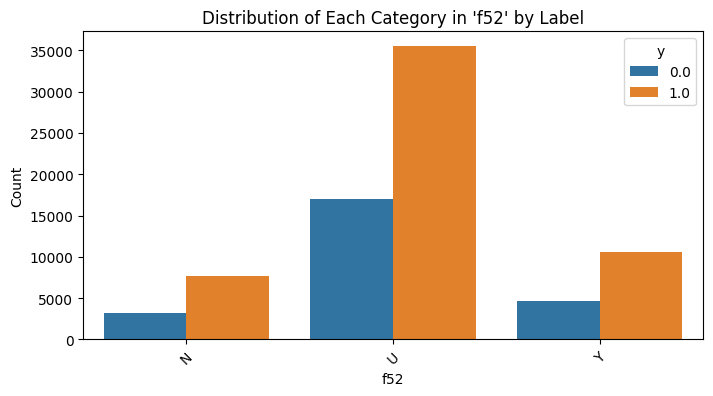

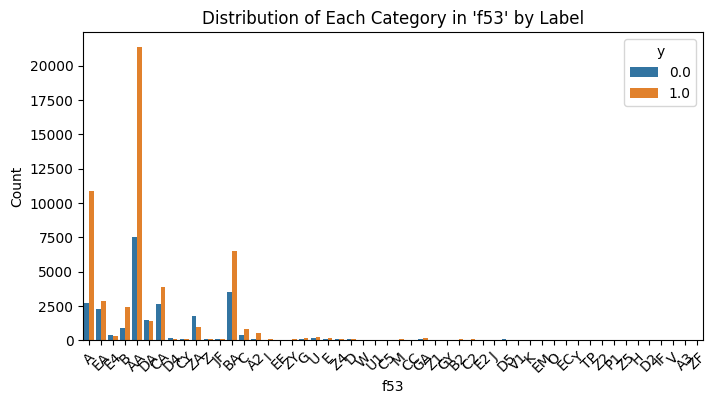

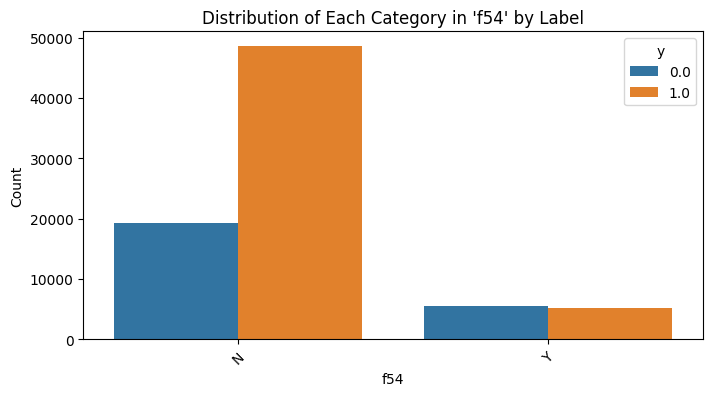

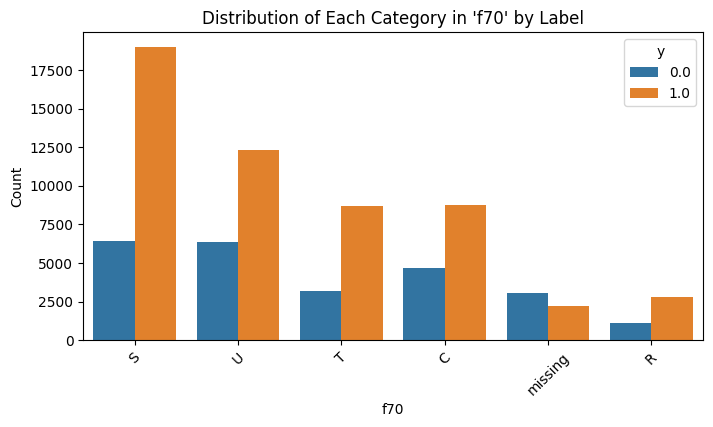

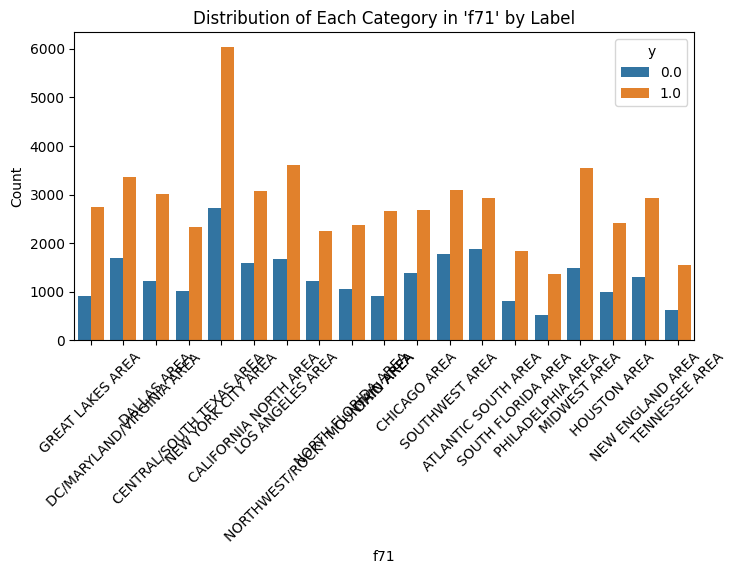

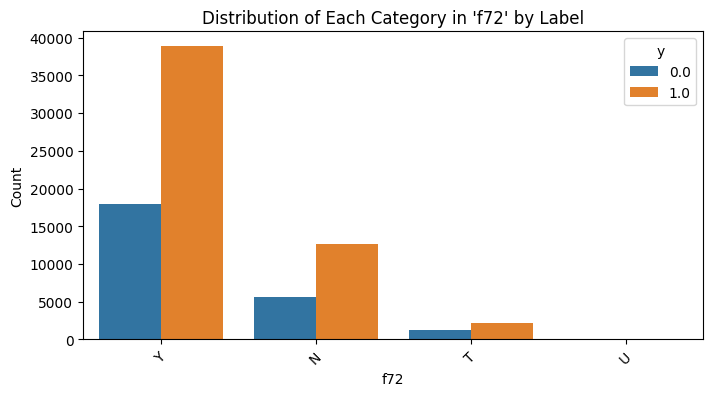

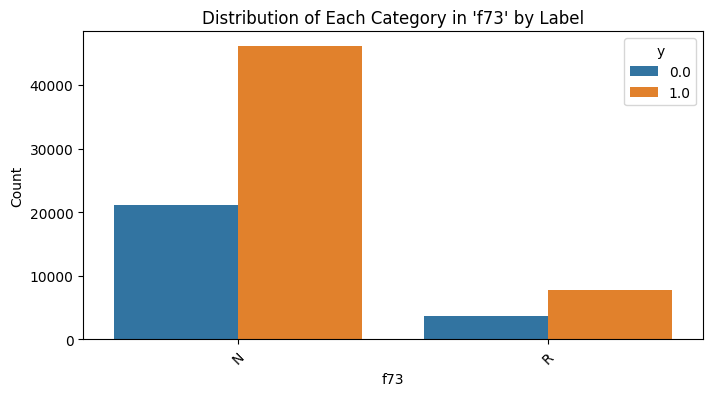

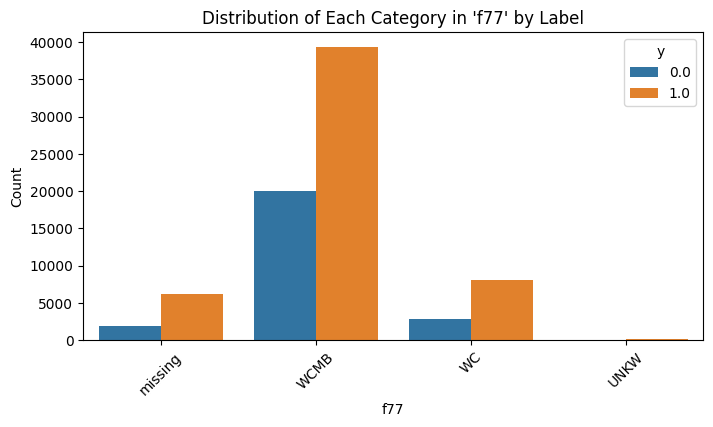

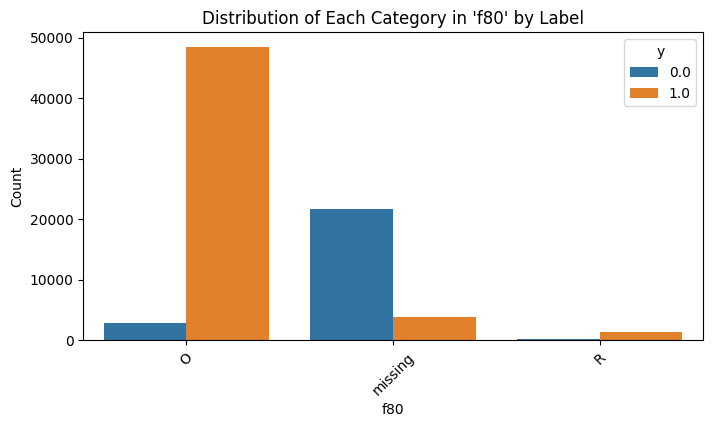

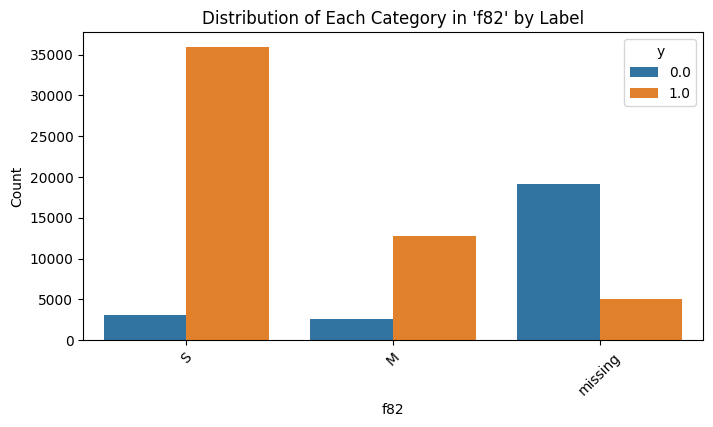

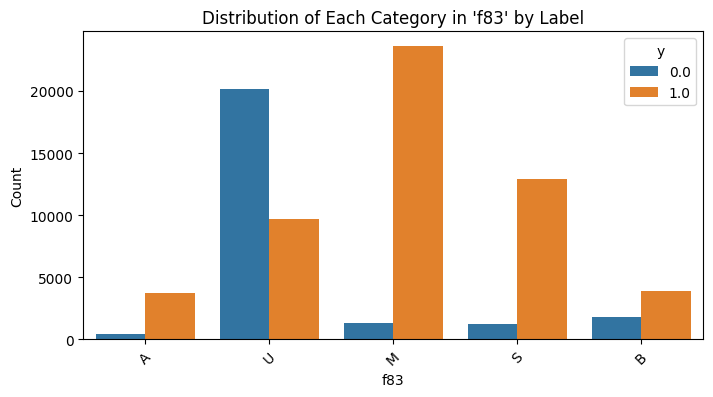

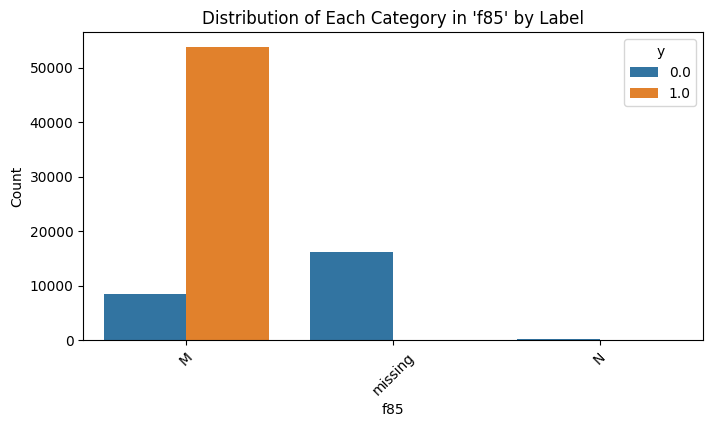

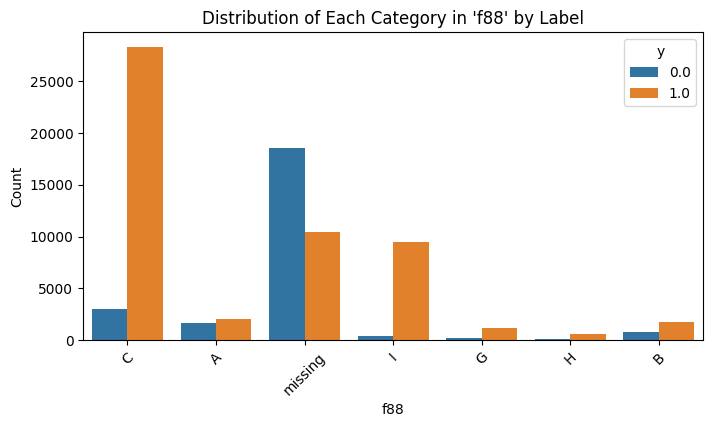

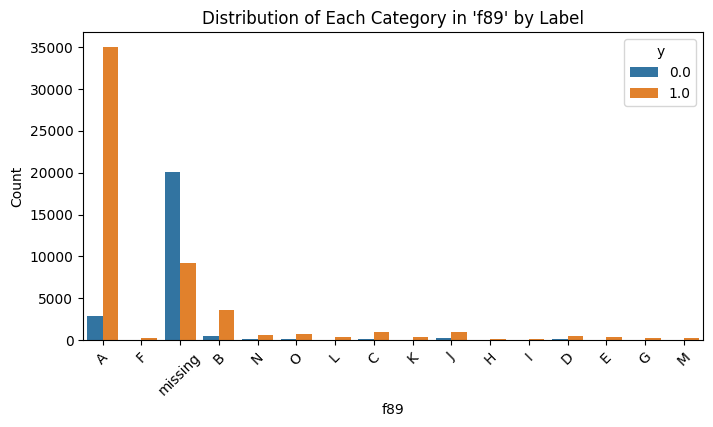

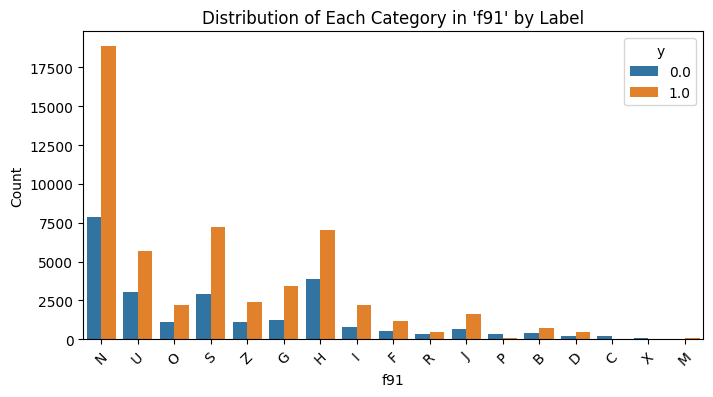

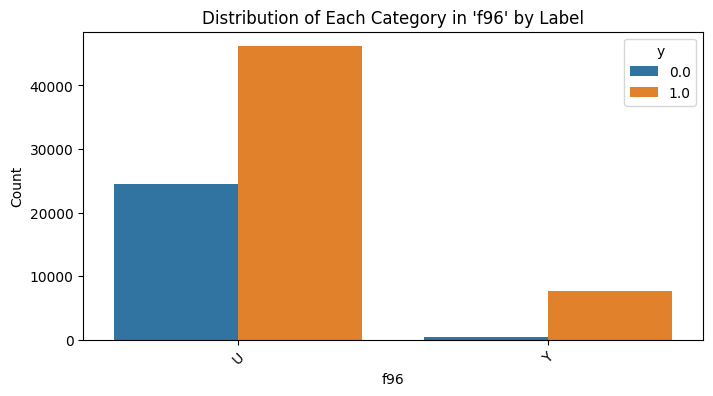

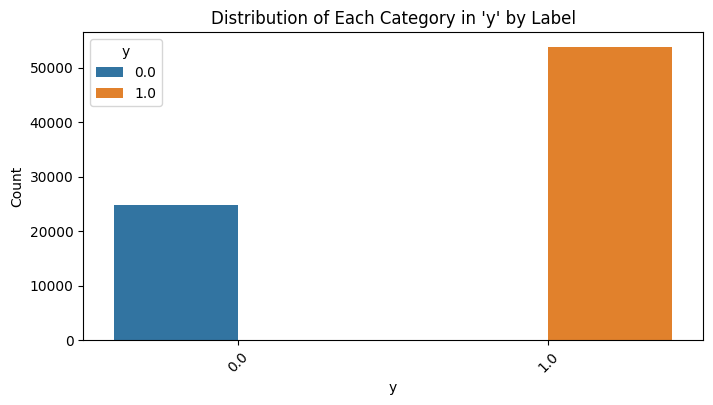

In [ ]:
# Plotting distribution of each category, including missing values, in each column associated with the label
for column in categorical_target_df:
    # Creating a temporary dataframe with missing values flagged as a category
    temp_df = categorical_target_df.copy()
    temp_df[column] = temp_df[column].fillna('Missing')

    # Plotting
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, hue='y', data=temp_df)
    plt.title(f"Distribution of Each Category in '{column}' by Label")
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()

f53, f85 và f91 cho ra IV = inf -> mẫu số gần 0 -> đề xuất thêm 1 giá trị rất nhỏ vào cả tử và mẫu số (cần xem xét lại cách thêm này)

Đoạn code phía dưới thêm epsilon = 1e-20 (1x10^-20)

In [ ]:
from tabulate import tabulate

def iv_woe_all_vars(data, target, iv_threshold, show_woe=True):
    iv_results = pd.DataFrame(columns=["Variable", "IV"])
    independent_vars = data.columns.difference([target])

    for ivars in independent_vars:
        d0 = data[[ivars, target]].copy()

        # Calculate counts for each category
        grouped = d0.groupby(ivars, as_index=False)
        d = pd.DataFrame(grouped[target].agg(['count', 'sum']))

        # Add a small constant to avoid division by zero
        epsilon = 1e-20
        d['Non-Events'] = d['count'] - d['sum']
        d['Non-Event Rate'] = (d['Non-Events'] + epsilon) / (d['count'] + epsilon)
        d['Event Rate'] = (d['sum'] + epsilon) / (d['count'] + epsilon)

        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d['IV'] = (d['Non-Event Rate'] - d['Event Rate']) * d['WOE']
        iv_value = d['IV'].sum()

        if show_woe:
            print("WOE and IV for", ivars)
            print(tabulate(d, headers='keys', tablefmt='pretty'))

        iv_results = pd.concat([iv_results, pd.DataFrame({"Variable": [ivars], "IV": [iv_value]})], ignore_index=True)

    iv_results = iv_results.sort_values(by='IV', ascending=False)
    selected_features = iv_results[iv_results['IV'] > iv_threshold]['Variable'].tolist()

    return iv_results, selected_features

# Apply the iv_woe_all_vars function to all variables in the categorical_target_df
iv_results_cat, selected_features_cat = iv_woe_all_vars(categorical_target_df, target='y', iv_threshold=0.1, show_woe=True)

# Display the IV results and the list of selected features for categorical variables
print("Information Value Results for Categorical Variables:")
print(tabulate(iv_results_cat, headers='keys', tablefmt='pretty'))


WOE and IV for f52
+-----+---------+---------+------------+---------------------+--------------------+---------------------+--------------------+
| f52 |  count  |   sum   | Non-Events |   Non-Event Rate    |     Event Rate     |         WOE         |         IV         |
+-----+---------+---------+------------+---------------------+--------------------+---------------------+--------------------+
|  N  | 10853.0 | 7641.0  |   3212.0   | 0.2959550354740625  | 0.7040449645259376 | -0.8666346885809144 | 0.3536648885768792 |
|  U  | 52504.0 | 35521.0 |  16983.0   | 0.32346106963278987 | 0.6765389303672101 | -0.7379112271581975 | 0.2605401174969272 |
|  Y  | 15257.0 | 10621.0 |   4636.0   | 0.3038605230386052  | 0.6961394769613948 | -0.8289812478618973 | 0.3251918967328738 |
+-----+---------+---------+------------+---------------------+--------------------+---------------------+--------------------+
WOE and IV for f53
+-----+---------+---------+------------+---------------------+-----------

Tất cả các cột đều có IV >0.1 => giữ lại tất cả các cột categorical

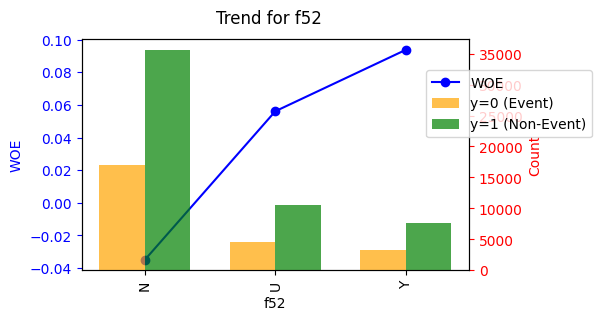

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


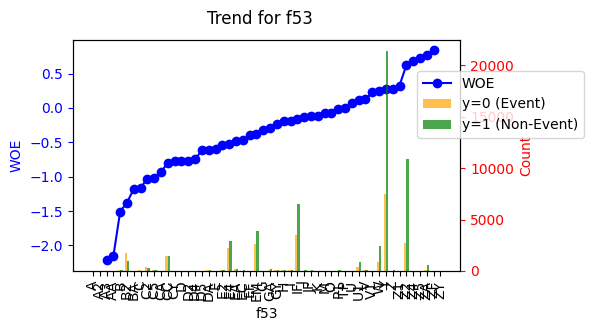

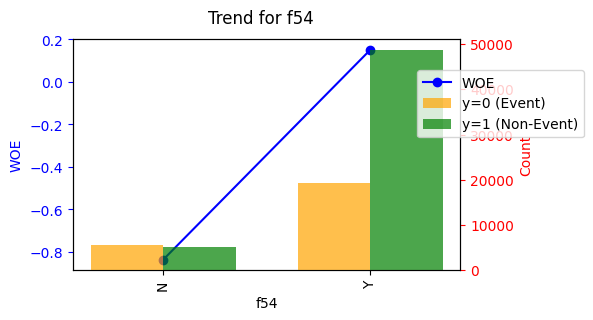

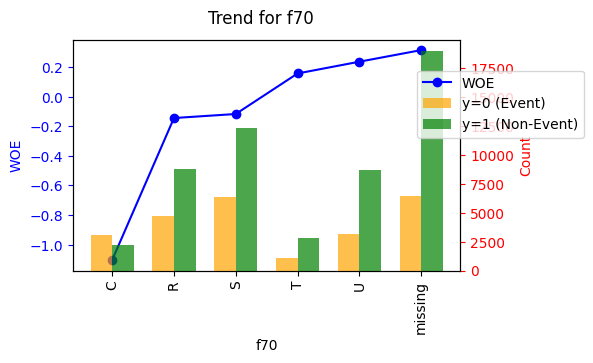

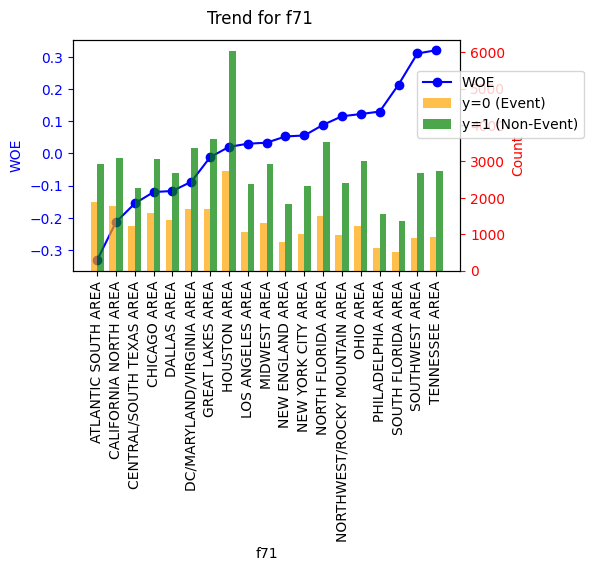

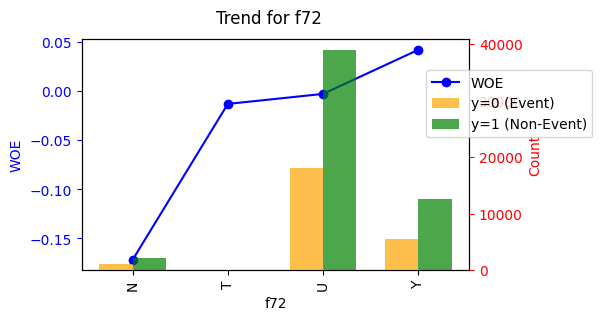

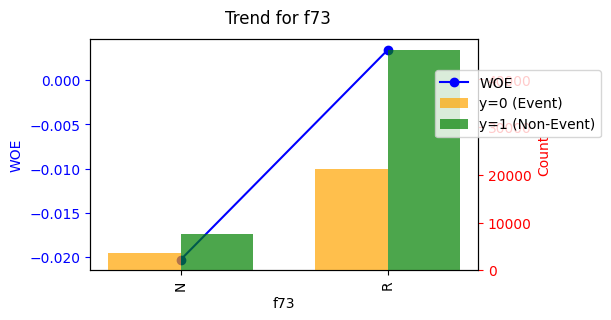

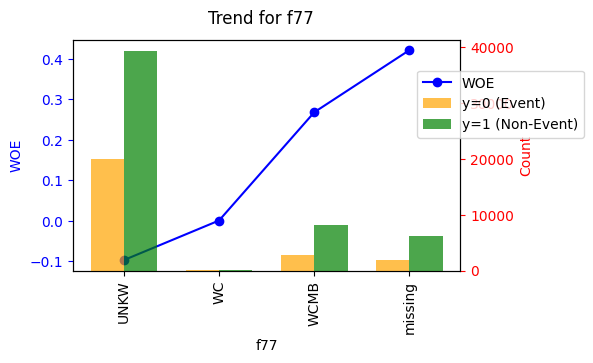

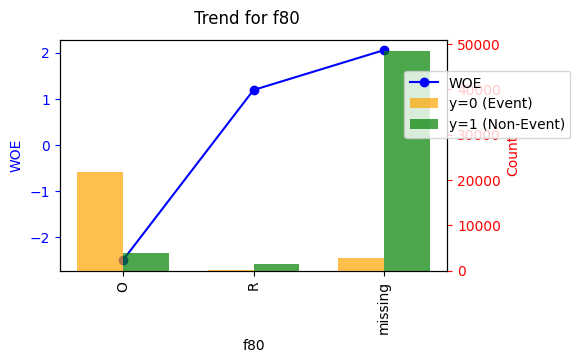

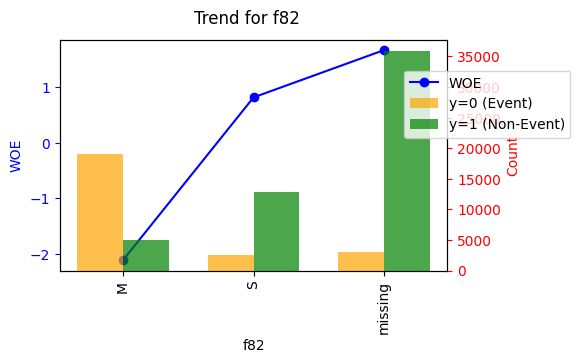

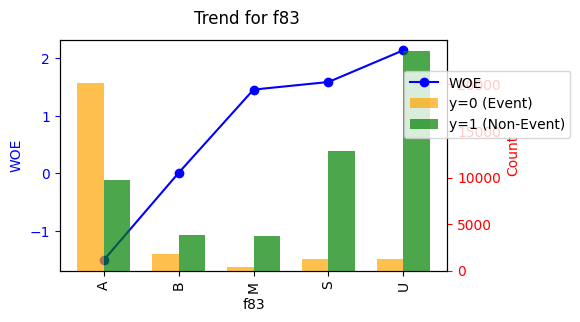

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


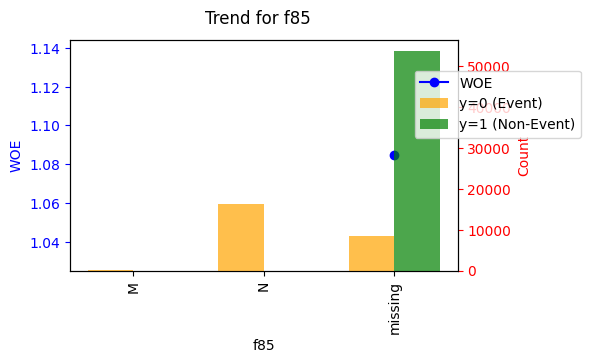

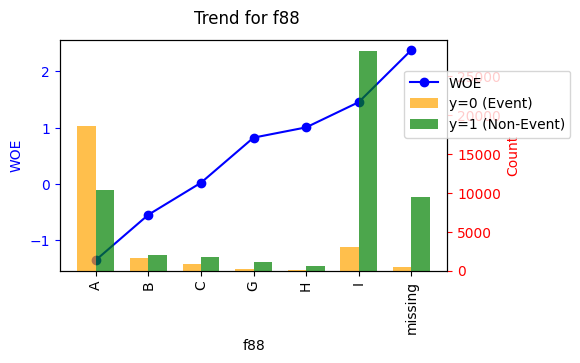

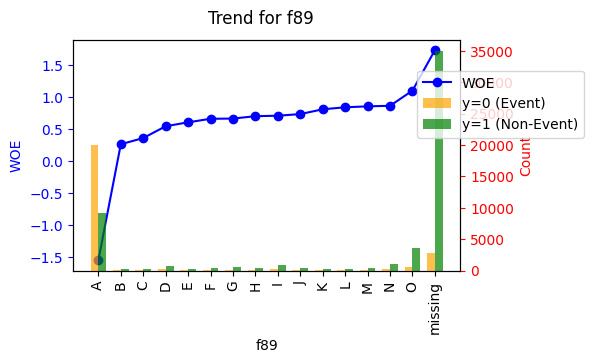

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


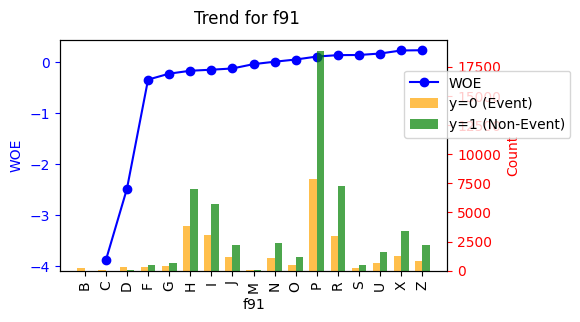

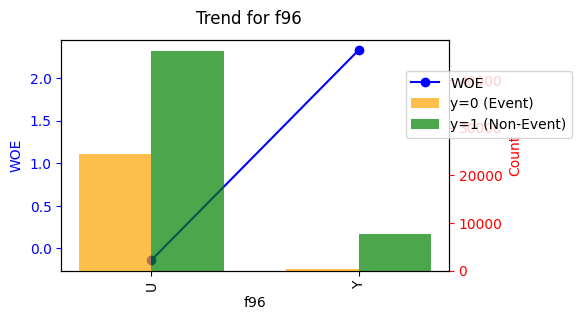

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_trend(data, variable, target, iv_bins):
    if pd.api.types.is_numeric_dtype(data[variable]):
        bins = pd.qcut(data[variable], q=iv_bins, duplicates='drop')
        data['bin'] = bins
        grouped = data.groupby('bin', as_index=False)
        d = pd.DataFrame(grouped[target].agg(['count', 'sum']))
        d.columns = ['Count', 'Non-Events']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d = d.sort_values(by='WOE')  # Sort by WOE values
        bin_labels = [str(bin) for bin in sorted(data['bin'].unique())]
        bin_midpoints = np.arange(len(bin_labels))
        bar_width = 0.35
    else:
        d = pd.DataFrame(data.groupby(variable, as_index=False).agg({target: ['count', 'sum']}))
        d.columns = ['Variable', 'Count', 'Non-Events']
        d['Events'] = d['Count'] - d['Non-Events']
        d['Event Rate'] = d['Events'] / d['Events'].sum()
        d['Non-Event Rate'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
        d = d.sort_values(by='WOE')  # Sort by WOE values
        bin_labels = [str(bin) for bin in sorted(data[variable].unique())]
        bin_midpoints = np.arange(len(bin_labels))
        bar_width = 0.35

    # Create a figure and axis for WOE
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot the WOE trend
    ax1.plot(bin_midpoints, d['WOE'], marker='o', color='b', label='WOE')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('WOE', color='b')
    ax1.set_xticks(bin_midpoints)
    ax1.set_xticklabels(bin_labels, rotation='vertical')
    ax1.tick_params('y', colors='b')

    # Create a secondary axis for Count of Events and Non-Events
    ax2 = ax1.twinx()

    # Plot the event and non-event trends side by side with different colors and labels
    ax2.bar(bin_midpoints - bar_width/2, d['Events'], label='y=0 (Event)', width=bar_width, alpha=0.7, color='orange')
    ax2.bar(bin_midpoints + bar_width/2, d['Non-Events'], label='y=1 (Non-Event)', width=bar_width, alpha=0.7, color='green')
    ax2.set_ylabel('Count', color='r')
    ax2.tick_params('y', colors='r')

    fig.suptitle(f'Trend for {variable}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.8, 0.8))

    plt.show()

# Plot the combined trends for all numeric features
for feature in categorical_target_df.columns:
    if feature != 'y':  # Skip the target variable
        plot_combined_trend(categorical_target_df, feature, 'y', iv_bins=10)


Các cột categorical đều có độ dốc lớn -> có thể giữ lại

In [ ]:
# Extract 'y' column and selected features from categorical_target_df
selected_columns = ['y'] + selected_features_cat
categorical_target_df = categorical_target_df[selected_columns]

# Create a separate WoE mapping dictionary for columns with IV > 0.1
woe_mapping_cat = {}

epsilon = 1e-20  # Add a small constant to avoid division by zero

for ivars in selected_features_cat:
    d0 = categorical_target_df[[ivars, 'y']].copy()

    # Use unique values for binning categorical columns
    unique_values = d0[ivars].unique()
    bins = pd.Series(range(len(unique_values)))
    grouped = d0.groupby(ivars, as_index=False)
    d = pd.DataFrame(grouped['y'].agg(['count', 'sum']))

    # Add epsilon to avoid division by zero
    d['Non-Event Rate'] = (d['count'] - d['sum'] + epsilon) / (d['count'] + epsilon)
    d['Event Rate'] = (d['sum'] + epsilon) / (d['count'] + epsilon)

    d['WOE'] = np.log(d['Non-Event Rate'] / d['Event Rate'])
    d['IV'] = (d['Non-Event Rate'] - d['Event Rate']) * d['WOE']
    iv_value = d['IV'].sum()

    # Use the unique values directly for mapping
    woe_mapping_cat[ivars] = dict(zip(unique_values, d['WOE']))

    # Map WoE values to the original DataFrame only for selected features
    categorical_target_df[ivars] = categorical_target_df[ivars].map(woe_mapping_cat[ivars])

# Handle missing values using backfill (bfill) only for missing values in each column
categorical_target_df = categorical_target_df.apply(lambda x: x.fillna(method='bfill'))
# Replace inf with a large positive or negative number in the entire DataFrame
categorical_target_df.replace([np.inf, -np.inf], [9999, -9999], inplace=True)

# Display the WoE mapping dictionary
print("WoE Mapping Dictionary:")
print(woe_mapping_cat)

# Display the DataFrame with replaced WoE values for selected features
print("\nDataFrame with replaced WoE values and missing values handled:")
print(categorical_target_df)


WoE Mapping Dictionary:
{'f53': {'A': -1.3954666123889992, 'EA': -1.54467337705667, 'E4': 0.0, 'B': -1.0467602952166328, 'AA': -1.014314051191065, 'DA': -0.6580558607486751, 'CA': -0.6172065535252802, 'D4': -0.8919499635376918, 'CY': -0.7576857016975164, 'ZA': -0.029852963149681274, 'Z': -0.38798236843575284, 'JF': -0.7731898882334818, 'BA': -0.5346768395881706, 'C': -0.23947997063390317, 'A2': 1.3862943611198906, 'I': 0.24807293435673516, 'EF': 0.3867729750960119, 'ZY': 0.02866326951197387, 'G': -0.47862968396550293, 'U': -0.45198512374305727, 'E': 0.2545298651348804, 'Z4': -0.25081782996906665, 'D': -0.3746934494414107, 'W': 0.0, 'U1': -0.661398482245365, 'C5': -0.8985911547747543, 'M': -0.5834482633035207, 'CC': -0.9985288301111273, 'GA': -0.6931471805599453, 'Z1': -1.0520922730332167, 'GY': 47.15031414854902, 'B2': -0.1823215567939546, 'C2': -0.5764229062518039, 'E2': -1.6094379124341005, 'J': -0.6466271649250525, 'D5': -1.5040773967762742, 'V1': 0.4054651081081642, 'K': -1.0986122

In [ ]:
# # Assuming train_raw and train_test are your DataFrames
# numeric_target_df.to_csv('/content/drive/My Drive/P28/Sample code/numeric_target_df.csv', index=False)
# categorical_target_df.to_csv('/content/drive/My Drive/P28/Sample code/categorical_target_df.csv', index=False)

# **3. Feature selection**

In [ ]:
# Chọn cột 'Customer ID' và 'y' từ train_df để tạo DataFrame mới
selected_columns = ['Customer_ID', 'y']
customer_y_df = train_df[selected_columns].copy()

# Loại bỏ cột y từ numeric_target_df
numeric_target_df = numeric_target_df.drop(columns=['y'])

# Loại bỏ cột y từ categorical_target_df
categorical_target_df = categorical_target_df.drop(columns=['y'])

In [ ]:
# Tạo cột index mới cho numeric_target_df
numeric_target_df['New Index'] = [f'Index_{i}' for i in range(len(numeric_target_df))]
# Tạo cột index mới cho categorical_target_df
categorical_target_df['New Index'] = [f'Index_{i}' for i in range(len(categorical_target_df))]
# Tạo cột index mới cho customer_y_df
customer_y_df['New Index'] = [f'Index_{i}' for i in range(len(customer_y_df))]

In [ ]:
# @title 2.7.1. Lọc biến bằng ngưỡng IV
# Set cột index mới làm index cho từng DataFrame
numeric_target_df = numeric_target_df.set_index('New Index')
categorical_target_df = categorical_target_df.set_index('New Index')
customer_y_df = customer_y_df.set_index('New Index')
# Ghép nối 3 DataFrame lại
merged_df = pd.concat([numeric_target_df, categorical_target_df, customer_y_df], axis=1)
# In ra DataFrame kết quả
print(merged_df)

                  f84       f81       f87       f86       f50       f75  \
New Index                                                                 
Index_0      3.850303  2.473739  4.759042  2.435571 -1.325092 -1.415289   
Index_1     -2.039923  0.020518 -0.879599  0.581334 -1.325092  1.594251   
Index_2     -2.039923 -3.519414 -0.879599 -2.432664 -1.325092 -1.415289   
Index_3      3.850303  1.730971  4.759042  1.853279 -1.325092 -1.415289   
Index_4     -2.039923  0.020518 -0.879599  2.435571 -1.325092 -1.415289   
...               ...       ...       ...       ...       ...       ...   
Index_78609 -2.039923  1.730971 -0.879599 -2.432664 -1.325092 -1.415289   
Index_78610  3.247340  3.478644 -0.879599  1.523460 -1.325092  0.756912   
Index_78611 -2.039923 -3.519414 -0.879599 -2.432664 -1.325092 -1.415289   
Index_78612 -2.039923 -3.519414 -0.879599  1.853279 -1.325092  1.594251   
Index_78613  2.222096  0.494453 -0.879599 -2.432664 -1.325092 -1.415289   

                  f76   

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78614 entries, Index_0 to Index_78613
Data columns (total 64 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   f84          78614 non-null  float64
 1   f81          78614 non-null  float64
 2   f87          78614 non-null  float64
 3   f86          78614 non-null  float64
 4   f50          78614 non-null  float64
 5   f75          78614 non-null  float64
 6   f76          78614 non-null  float64
 7   f8           78614 non-null  float64
 8   f27          78614 non-null  float64
 9   f22          78614 non-null  float64
 10  f7.1         78614 non-null  float64
 11  f29          78614 non-null  float64
 12  f18          78614 non-null  float64
 13  f51          78614 non-null  float64
 14  f38          78614 non-null  float64
 15  f42          78614 non-null  float64
 16  f4           78614 non-null  float64
 17  f47          78614 non-null  float64
 18  f23          78614 non-null  float64
 1

Loại bỏ tổng cộng 16 cột float và 0 cột object

Số cột ban đầu là 69 biến đặc trưng (float64), cột Customer_ID, cột y và 16 biến đặc trưng (object) => 87 cột

Số cột được chọn sau khi loại bỏ IV<0.1: 53 cột float, cột y, cột Customer_ID và 16 cột categorical => 71 cột còn lại

In [ ]:
# @title 2.7.2. Lọc biến bằng Corr matrix

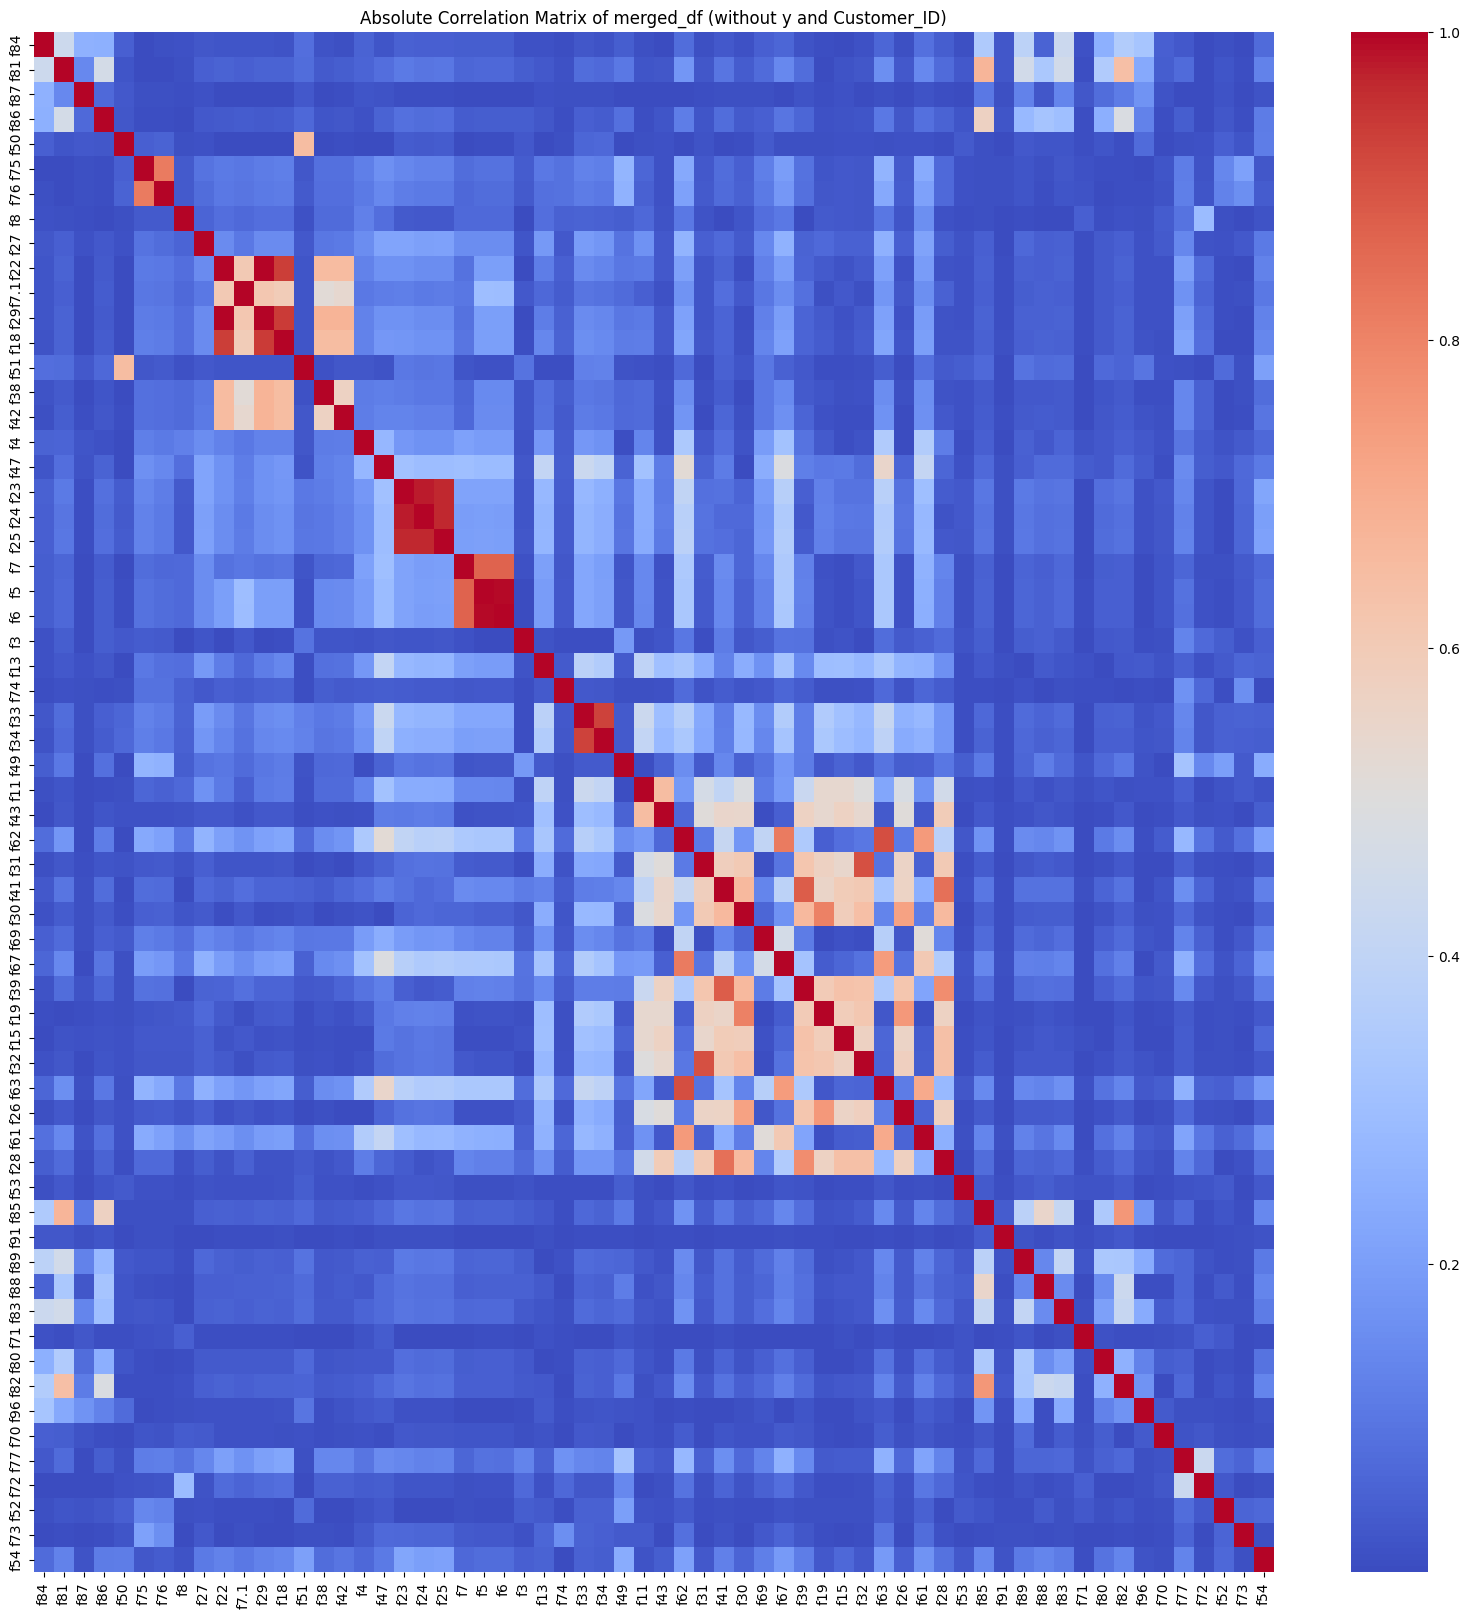

In [ ]:
# Loại bỏ cột 'y' và 'Customer_ID' từ merged_df
merged_df_no_y_id = merged_df.drop(columns=['y', 'Customer_ID'])

# Tính ma trận tương quan tuyệt đối
absolute_correlation_matrix = merged_df_no_y_id.corr().abs()
# Tăng kích thước của hình
plt.figure(figsize=(20, 20))
# Vẽ ma trận tương quan tuyệt đối sử dụng seaborn
sns.heatmap(absolute_correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Absolute Correlation Matrix of merged_df (without y and Customer_ID)')
plt.show()

In [ ]:
# Loại bỏ cột "y" và "Customer_ID" khỏi danh sách cột
exclude_columns = ["y", "Customer_ID"]
included_columns = [col for col in absolute_correlation_matrix.columns if col not in exclude_columns]

# Tạo một DataFrame mới chỉ chứa các cột không bị loại bỏ
filtered_correlation_matrix = absolute_correlation_matrix[included_columns]

# Sắp xếp các cặp theo thứ tự giảm dần của hệ số tương quan
sorted_pairs = filtered_correlation_matrix.unstack().sort_values(ascending=False)

# Lọc ra các cặp có hệ số tương quan tuyệt đối lớn hơn 0.6
filtered_pairs = sorted_pairs[(sorted_pairs > 0.6) & (sorted_pairs < 1.0)]

# Tạo một từ điển để lưu trữ số lần xuất hiện của mỗi cột
column_counts = {}

# In ra số lần xuất hiện của mỗi cột trong các cặp có hệ số tương quan trên 0.6
print("Số lần xuất hiện của mỗi cột trong các cặp có hệ số tương quan trên 0.6:")
for (col1, col2), correlation_value in filtered_pairs.iteritems():
    # Kiểm tra nếu cột "Customer_ID" xuất hiện trong cặp, thì bỏ qua
    if "Customer_ID" in [col1, col2]:
        continue

    # Tăng số lần xuất hiện của từng cột trong cặp
    for col in [col1, col2]:
        column_counts[col] = column_counts.get(col, 0) + 1

# Loại bỏ các cột xuất hiện trong quá nhiều cặp
threshold = 2
columns_to_remove = [col for col, count in column_counts.items() if count > threshold]

# In ra các cột sẽ bị loại bỏ
print(f"\nCác cột sẽ bị loại bỏ vì xuất hiện trong quá nhiều cặp ({threshold} lần trở lên):")
print(columns_to_remove)

# Loại bỏ các cột từ DataFrame chính
filtered_correlation_matrix = filtered_correlation_matrix.drop(columns=columns_to_remove)



Số lần xuất hiện của mỗi cột trong các cặp có hệ số tương quan trên 0.6:

Các cột sẽ bị loại bỏ vì xuất hiện trong quá nhiều cặp (2 lần trở lên):
['f22', 'f29', 'f5', 'f6', 'f24', 'f23', 'f25', 'f18', 'f63', 'f62', 'f31', 'f32', 'f41', 'f39', 'f7', 'f28', 'f67', 'f30', 'f19', 'f85', 'f82', 'f26', 'f61', 'f38', 'f42', 'f81', 'f15', 'f7.1']


<ipython-input-181-117999dfae60>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (col1, col2), correlation_value in filtered_pairs.iteritems():


In [ ]:
# Kiểm tra xem còn cặp nào có hệ số tương quan tuyệt đối lớn hơn 0.6 không
remaining_pairs = filtered_correlation_matrix.unstack().sort_values(ascending=False)
remaining_pairs = remaining_pairs[(remaining_pairs > 0.6) & (remaining_pairs < 1.0)]

if remaining_pairs.empty:
    print("\nKhông còn cặp nào có hệ số tương quan tuyệt đối lớn hơn 0.6.")
else:
    print("\nCòn các cặp sau có hệ số tương quan tuyệt đối lớn hơn 0.6:")
    print(remaining_pairs.to_string())



Còn các cặp sau có hệ số tương quan tuyệt đối lớn hơn 0.6:
f33  f34    0.929449
f34  f33    0.929449
f76  f75    0.817230
f75  f76    0.817230
f11  f43    0.650336
f43  f11    0.650336
f51  f50    0.648875
f50  f51    0.648875


f33-f34: chọn f33 vì IV cao

f75-f76: chọn f75

f11-f43: chọn f11

f50-f51: chọn f50

In [ ]:
# Bổ sung các cột cần loại bỏ vào danh sách
additional_columns_to_remove = ["f34", "f76", "f43", "f51"]
columns_to_remove.extend(additional_columns_to_remove)

# In ra các cột sẽ bị loại bỏ sau khi bổ sung
print(f"\nCác cột sẽ bị loại bỏ vì xuất hiện trong quá nhiều cặp ({threshold} lần trở lên):")
print(columns_to_remove)


Các cột sẽ bị loại bỏ vì xuất hiện trong quá nhiều cặp (2 lần trở lên):
['f22', 'f29', 'f5', 'f6', 'f24', 'f23', 'f25', 'f18', 'f63', 'f62', 'f31', 'f32', 'f41', 'f39', 'f7', 'f28', 'f67', 'f30', 'f19', 'f85', 'f82', 'f26', 'f61', 'f38', 'f42', 'f81', 'f15', 'f7.1', 'f34', 'f76', 'f43', 'f51']


In [ ]:
# Loại bỏ các cột từ merged_df
merged_df = merged_df.drop(columns=columns_to_remove, errors='ignore')

# In ra DataFrame sau khi loại bỏ
print("\nDataFrame sau khi loại bỏ các cột:")
print(merged_df)


DataFrame sau khi loại bỏ các cột:
                  f84       f87       f86       f50       f75        f8  \
New Index                                                                 
Index_0      3.850303  4.759042  2.435571 -1.325092 -1.415289  1.221254   
Index_1     -2.039923 -0.879599  0.581334 -1.325092  1.594251  1.012994   
Index_2     -2.039923 -0.879599 -2.432664 -1.325092 -1.415289 -1.924110   
Index_3      3.850303  4.759042  1.853279 -1.325092 -1.415289  1.075766   
Index_4     -2.039923 -0.879599  2.435571 -1.325092 -1.415289 -1.924110   
...               ...       ...       ...       ...       ...       ...   
Index_78609 -2.039923 -0.879599 -2.432664 -1.325092 -1.415289  0.890318   
Index_78610  3.247340 -0.879599  1.523460 -1.325092  0.756912 -1.924110   
Index_78611 -2.039923 -0.879599 -2.432664 -1.325092 -1.415289 -1.924110   
Index_78612 -2.039923 -0.879599  1.853279 -1.325092  1.594251  1.002733   
Index_78613  2.222096 -0.879599 -2.432664 -1.325092 -1.415289 -1

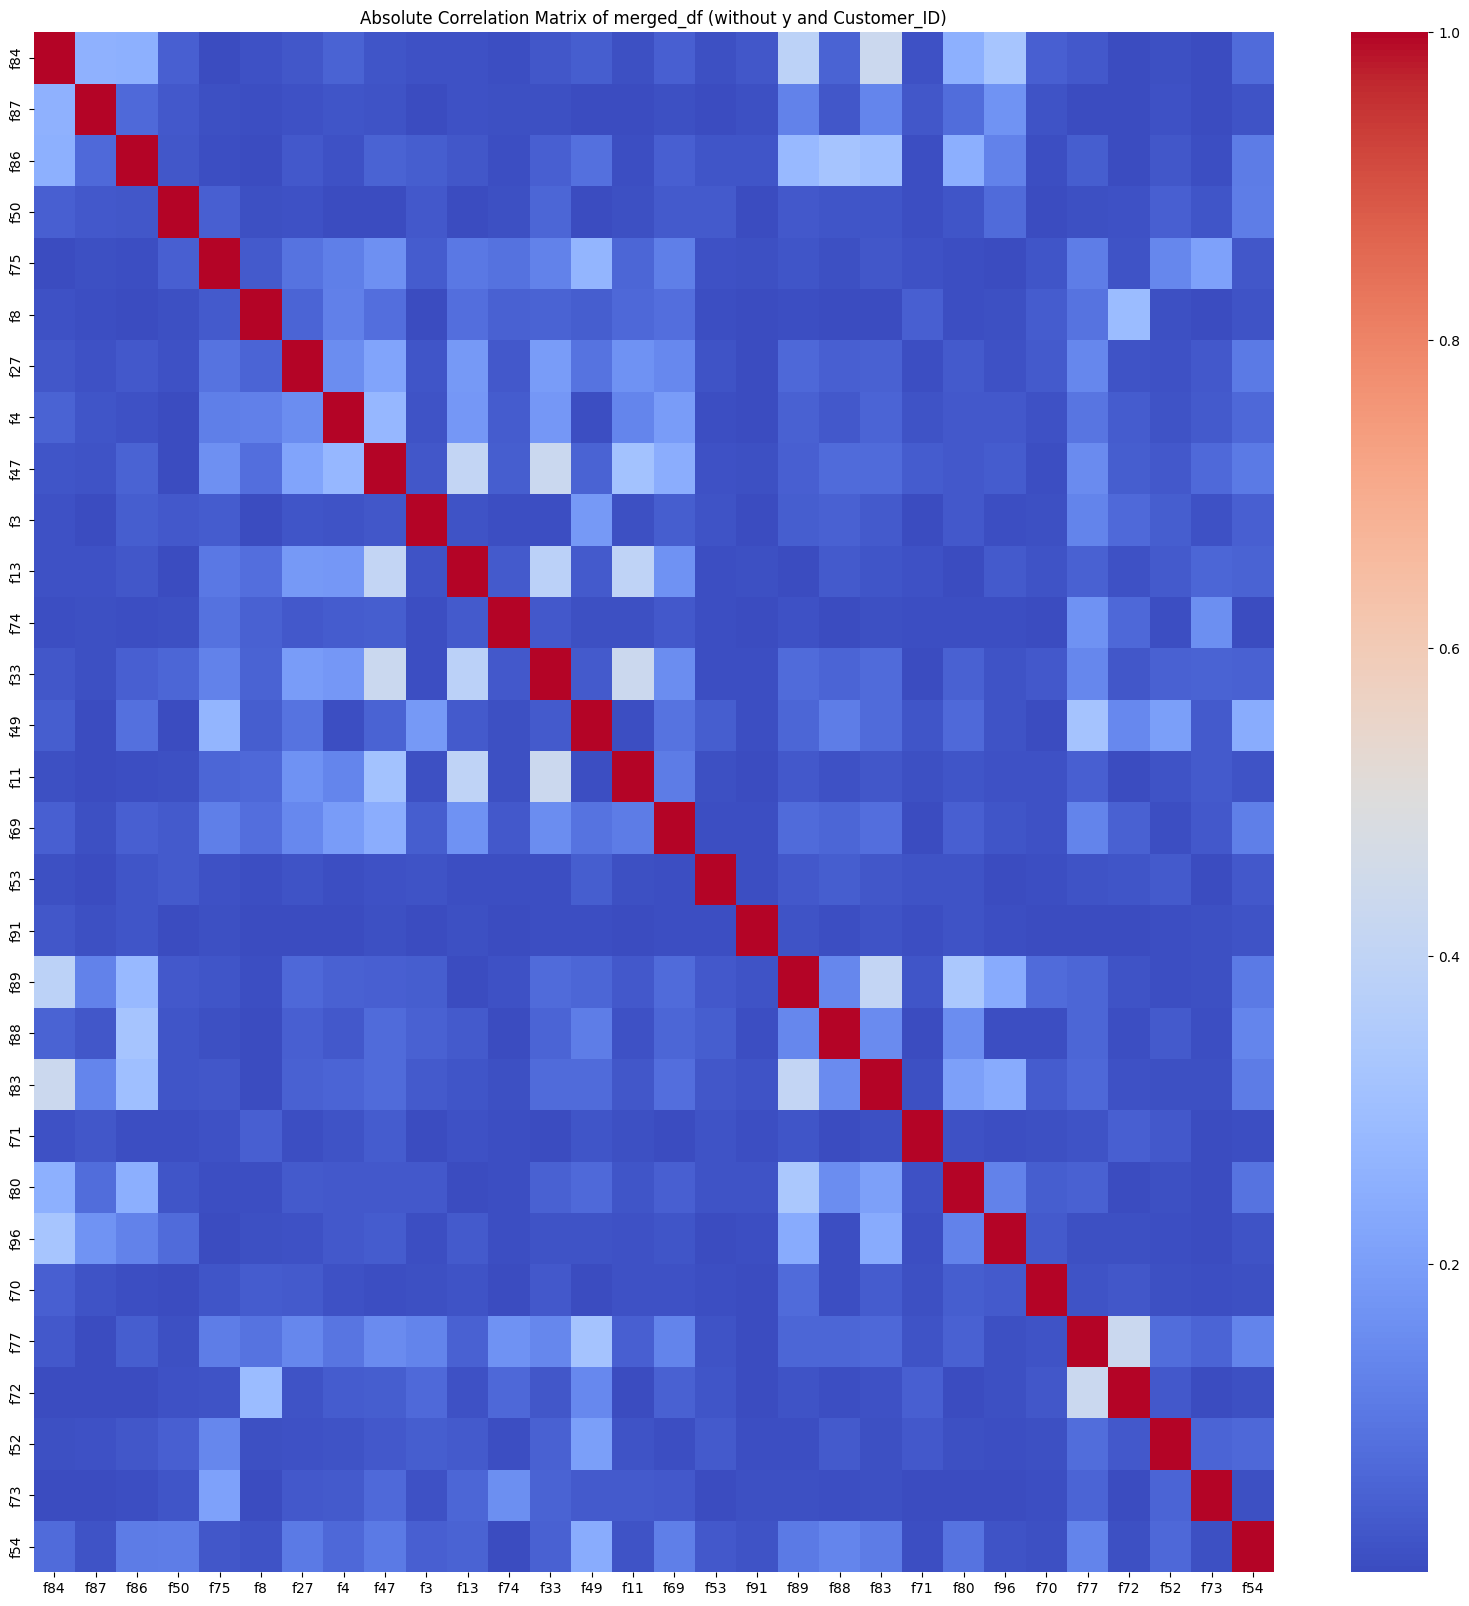

In [ ]:
# Loại bỏ cột 'y' và 'Customer_ID' từ merged_df
merged_df_no_y_id = merged_df.drop(columns=['y', 'Customer_ID'])

# Tính ma trận tương quan tuyệt đối
new_absolute_correlation_matrix = merged_df_no_y_id.corr().abs()
# Tăng kích thước của hình
plt.figure(figsize=(20, 20))
# Vẽ ma trận tương quan tuyệt đối sử dụng seaborn
sns.heatmap(new_absolute_correlation_matrix , annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Absolute Correlation Matrix of merged_df (without y and Customer_ID)')
plt.show()

In [ ]:
# @title 2.6.3. Transform cho X_test
X_test_missing_handled.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
test_df = pd.concat([X_test_missing_handled, y_test], axis=1)
# Danh sách các cột chung
common_columns = list(set(merged_df.columns).intersection(test_df.columns))
# Chọn chỉ các cột chung trong test_df
test_df = test_df[common_columns]
# In ra DataFrame test sau khi giữ lại các cột chung
print("\nDataFrame test sau khi giữ lại các cột chung:")
test_df.info()


DataFrame test sau khi giữ lại các cột chung:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19654 entries, 0 to 19653
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   f73          19654 non-null  object 
 1   f71          19654 non-null  object 
 2   f8           19654 non-null  float64
 3   f11          19654 non-null  float64
 4   f74          19654 non-null  float64
 5   f77          19654 non-null  object 
 6   f87          19654 non-null  float64
 7   f84          19654 non-null  float64
 8   y            19654 non-null  float64
 9   f3           19654 non-null  float64
 10  f96          19654 non-null  object 
 11  f4           19654 non-null  float64
 12  f83          19654 non-null  object 
 13  f72          19654 non-null  object 
 14  f54          19654 non-null  object 
 15  f50          19654 non-null  float64
 16  f53          19654 non-null  object 
 17  f75          19654 non-null  float64
 18 

In [ ]:
# Lọc ra các cột numeric và cột 'y' từ DataFrame hiện tại (test_df)
numeric_test_target_df = test_df.loc[:, test_df.select_dtypes(include=[np.number]).columns.union(['y'])].drop(columns=['Customer_ID'])
# Lọc ra các cột categorical và cột 'y' từ DataFrame hiện tại (test_df)
categorical_test_target_df = test_df.loc[:, test_df.select_dtypes(include=['object']).columns.union(['y'])]

In [ ]:
# Áp dụng hàm iv_woe_all_vars cho tất cả các biến trong tập test_df
iv_results_test, selected_features_test = iv_woe_all_vars(numeric_test_target_df, target='y', iv_threshold=0.1, show_woe=False)

# Tạo một separate WoE mapping dictionary cho các cột với IV > 0.1
woe_mapping_num_test = {}

for ivars in selected_features_test:
    # Sử dụng giá trị WoE từ train_df thay vì tính toán lại từ numeric_test_target_df
    woe_mapping_num_test[ivars] = woe_mapping_num[ivars]

    # Map giá trị WoE vào DataFrame gốc chỉ cho các tính năng được chọn
    numeric_test_target_df[ivars] = numeric_test_target_df[ivars].map(woe_mapping_num_test[ivars])

# Xử lý giá trị thiếu row-wise
for index, row in numeric_test_target_df.iterrows():
    for col in selected_features_test:
        # Nếu giá trị hiện tại là NaN và không phải là dòng đầu tiên, sử dụng giá trị từ dòng trước đó
        if pd.isnull(row[col]) and index > 0:
            numeric_test_target_df.at[index, col] = numeric_test_target_df.at[index - 1, col]

# Hiển thị WoE mapping dictionary
print("WoE Mapping Dictionary for Test Data:")
print(woe_mapping_num_test)

# Hiển thị DataFrame với giá trị WoE đã được thay thế và giá trị thiếu được xử lý cho các tính năng được chọn
print("\nDataFrame with replaced WoE values and missing values handled for Test Data:")
numeric_test_target_df.info()


WoE Mapping Dictionary for Test Data:
{'f3': {Interval(-26.916, 10.0, closed='right'): -0.19783890689504527, Interval(10.0, 18.331, closed='right'): 1.2786166117709301, Interval(18.331, 26.66, closed='right'): 0.5259860448802659, Interval(26.66, 29.99, closed='right'): -0.3792540187938624, Interval(29.99, 30.0, closed='right'): 0.329451284120533, Interval(30.0, 32.49, closed='right'): 1.1395061002860345, Interval(32.49, 34.98, closed='right'): 0.8338408289875454, Interval(34.98, 39.99, closed='right'): -0.6798217401159283, Interval(39.99, 43.78, closed='right'): 0.3699794184730616, Interval(43.78, 44.99, closed='right'): -1.105288919483302, Interval(44.99, 46.28, closed='right'): 1.5507102642578419, Interval(46.28, 49.99, closed='right'): -0.4865537063469001, Interval(49.99, 52.115, closed='right'): 0.43249540689678373, Interval(52.115, 57.49, closed='right'): 0.08758348314199672, Interval(57.49, 59.99, closed='right'): -0.8803614375892692, Interval(59.99, 62.99, closed='right'): 1.267

In [ ]:
# Apply the iv_woe_all_vars function to all variables in the categorical_target_df
iv_results_cat, selected_features_cat_test = iv_woe_all_vars(categorical_test_target_df, target='y', iv_threshold=0.1, show_woe=True)
# Tạo một separate WoE mapping dictionary cho các cột với IV > 0.1
woe_mapping_cat_test = {}

for ivars in selected_features_cat_test:
    # Sử dụng giá trị WoE từ train_df thay vì tính toán lại từ numeric_test_target_df
    woe_mapping_cat_test[ivars] = woe_mapping_cat[ivars]

    # Map giá trị WoE vào DataFrame gốc chỉ cho các tính năng được chọn
    categorical_test_target_df[ivars] = categorical_test_target_df[ivars].map(woe_mapping_cat_test[ivars])

# Xử lý giá trị thiếu row-wise
for index, row in categorical_test_target_df.iterrows():
    for col in selected_features_cat_test:
        # Nếu giá trị hiện tại là NaN và không phải là dòng đầu tiên, sử dụng giá trị từ dòng trước đó
        if pd.isnull(row[col]) and index > 0:
            categorical_test_target_df.at[index, col] = categorical_test_target_df.at[index - 1, col]

# Hiển thị WoE mapping dictionary
print("WoE Mapping Dictionary for Test Data:")
print(woe_mapping_cat_test)

# Hiển thị DataFrame với giá trị WoE đã được thay thế và giá trị thiếu được xử lý cho các tính năng được chọn
print("\nDataFrame with replaced WoE values and missing values handled for Test Data:")
categorical_test_target_df.info()


WOE and IV for f52
+-----+---------+--------+------------+--------------------+--------------------+---------------------+--------------------+
| f52 |  count  |  sum   | Non-Events |   Non-Event Rate   |     Event Rate     |         WOE         |         IV         |
+-----+---------+--------+------------+--------------------+--------------------+---------------------+--------------------+
|  N  | 2689.0  | 1876.0 |   813.0    | 0.3023428783934548 | 0.6976571216065451 | -0.8361660200183594 | 0.3305483374040595 |
|  U  | 13234.0 | 9028.0 |   4206.0   | 0.3178177421792353 | 0.6821822578207647 | -0.7638187816747811 | 0.2783084604228347 |
|  Y  | 3731.0  | 2547.0 |   1184.0   | 0.3173411953899759 | 0.6826588046100242 | -0.7660176595355059 | 0.2798397400018479 |
+-----+---------+--------+------------+--------------------+--------------------+---------------------+--------------------+
WOE and IV for f53
+-----+--------+--------+------------+---------------------+------------------------+--

In [ ]:
# Chọn cột 'Customer ID' và 'y' từ train_df để tạo DataFrame mới
selected_columns = ['Customer_ID', 'y']
customer_y_test_df = test_df[selected_columns].copy()

# Loại bỏ cột y từ numeric_target_df
numeric_test_target_df = numeric_test_target_df.drop(columns=['y'])

# Loại bỏ cột y từ categorical_target_df
categorical_test_target_df = categorical_test_target_df.drop(columns=['y'])

In [ ]:
# Tạo cột index mới cho numeric_target_df
numeric_test_target_df['New Index'] = [f'Index_{i}' for i in range(len(numeric_test_target_df))]
# Tạo cột index mới cho categorical_target_df
categorical_test_target_df['New Index'] = [f'Index_{i}' for i in range(len(categorical_test_target_df))]
# Tạo cột index mới cho customer_y_df
customer_y_test_df['New Index'] = [f'Index_{i}' for i in range(len(customer_y_test_df))]

In [ ]:
# Set cột index mới làm index cho từng DataFrame
numeric_test_target_df = numeric_test_target_df.set_index('New Index')
categorical_test_target_df = categorical_test_target_df.set_index('New Index')
customer_y_test_df = customer_y_test_df.set_index('New Index')
# Ghép nối 3 DataFrame lại
test_merged_df = pd.concat([numeric_test_target_df, categorical_test_target_df, customer_y_test_df], axis=1)
# In ra DataFrame kết quả
print(test_merged_df)

                  f11       f13       f27        f3       f33        f4  \
New Index                                                                 
Index_0     -0.192841  0.565674  1.865249 -0.880361  0.326220  1.155666   
Index_1      0.204571  0.461990 -1.337465  0.329451  0.575665 -1.805421   
Index_2      0.322297 -0.316109 -1.337465  0.388978 -1.747891 -1.805421   
Index_3      0.064356  0.942493 -1.337465 -0.679822 -1.747891 -1.805421   
Index_4      0.458217 -0.316109 -1.337465 -0.679822 -1.747891 -1.805421   
...               ...       ...       ...       ...       ...       ...   
Index_19649  0.458217  0.461990 -1.337465  0.087583  0.175792 -1.805421   
Index_19650 -0.166623 -1.732294 -1.337465 -1.105289  0.303352 -1.805421   
Index_19651 -1.366294 -1.732294 -1.337465 -0.486554 -1.747891 -1.805421   
Index_19652 -1.366294 -1.732294 -1.337465 -1.105289 -1.747891  0.809687   
Index_19653 -1.366294  0.461990 -1.337465 -1.105289  0.380845 -1.805421   

                  f47   

# Nháp

In [ ]:
import pandas as pd
import numpy as np

def calculate_psi(train, test, variable, bins=10):
    train_dist = pd.cut(train[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)
    test_dist = pd.cut(test[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)

    psi_values = (train_dist - test_dist) * np.log(train_dist / test_dist)
    psi = psi_values.sum()

    return psi

def calculate_psi_for_all_variables(train_df, test_df, bins=10):
    psi_results = []

    for variable in train_df.columns:
        psi_result = calculate_psi(train_df, test_df, variable, bins=bins)
        psi_results.append({'Variable': variable, 'PSI': psi_result})

    return pd.DataFrame(psi_results)

# Thay thế X_train_encoded và X_test_encoded cho train_df và test_df
psi_results_df = calculate_psi_for_all_variables(X_train_no_outliers, X_test_by_woe)
print(psi_results_df.to_string())


So sánh phân phối giữa X_train và X_test cho thấy không có sự thay đổi đáng kể nào trong phân phối

In [ ]:
def calculate_psi(train, test, variable, bins=10):
    train_dist = pd.cut(train[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)
    test_dist = pd.cut(test[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)

    psi_values = (train_dist - test_dist) * np.log(train_dist / test_dist)
    psi = psi_values.sum()

    return psi

def filter_variables_by_psi(train_df, test_df, threshold=0.25, bins=10):
    psi_results = []

    for variable in train_df.columns:
        psi_result = calculate_psi(train_df, test_df, variable, bins=bins)
        psi_results.append({'Variable': variable, 'PSI': psi_result})

    psi_results_df = pd.DataFrame(psi_results)
    selected_variables = psi_results_df[psi_results_df['PSI'] >= threshold]['Variable'].tolist()

    return train_df[selected_variables], test_df[selected_variables]

filtered_train_df, filtered_test_df = filter_variables_by_psi(X_train_no_outliers, X_test_by_woe, threshold=0.25)
print("Filtered Train Data:")
print(filtered_train_df)
print("\nFiltered Test Data:")
print(filtered_test_df)

Không có biến nào có PSI vượt ngưỡng -> không cần loại bỏ biến

In [ ]:
import pandas as pd
import numpy as np

def calculate_psi(train, test, variable, bins=10):
    train_dist = pd.cut(train[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)
    test_dist = pd.cut(test[variable], bins=bins, include_lowest=True, right=True).value_counts(normalize=True)

    psi_values = (train_dist - test_dist) * np.log(train_dist / test_dist)
    psi = psi_values.sum()

    return psi

def calculate_psi_for_all_variables(train_df, test_df, bins=10):
    psi_results = []

    for variable in train_df.columns:
        psi_result = calculate_psi(train_df, test_df, variable, bins=bins)
        psi_results.append({'Variable': variable, 'PSI': psi_result})

    return pd.DataFrame(psi_results)

# Thay thế X_train_encoded và X_test_encoded cho train_df và test_df
psi_results_df = calculate_psi_for_all_variables(X_train_woe, X_test_woe)
print(psi_results_df.to_string())


# Xuất file


In [ ]:
merged_df.head(5)

,f84,f87,f86,f50,f75,f8,f27,f4,f47,f3,...,f80,f96,f70,f77,f72,f52,f73,f54,Customer_ID,y
New Index,,,,,,,,,,,,,,,,,,,,,
Index_0,3.850303,4.759042,2.435571,-1.325092,-1.415289,1.221254,-1.337465,0.797153,-1.781350,-0.379254,...,-2.826658,-0.633495,-0.628409,-0.773190,-0.814899,-0.866635,-0.776298,-0.923686,1016305.0,1.0
Index_1,-2.039923,-0.879599,0.581334,-1.325092,1.594251,1.012994,1.830434,0.992076,0.970854,-0.349251,...,-1.960725,-0.633495,-0.929370,-1.040712,-0.814899,-0.737911,-0.752555,-0.923686,1049405.0,0.0
Index_2,-2.039923,-0.879599,-2.432664,-1.325092,-1.415289,-1.924110,-1.337465,-1.805421,-1.781350,-0.288364,...,-1.960725,-0.633495,-1.087251,-1.040712,-0.814899,-0.737911,-0.776298,0.064117,1097456.0,0.0
Index_3,3.850303,4.759042,1.853279,-1.325092,-1.415289,1.075766,1.088528,0.154495,0.970854,0.432495,...,-2.826658,-0.633495,-1.008905,-1.040712,-0.814899,-0.737911,-0.776298,-0.923686,1016712.0,1.0
Index_4,-2.039923,-0.879599,2.435571,-1.325092,-1.415289,-1.924110,-1.337465,-1.805421,-1.781350,-0.679822,...,-2.826658,-0.633495,-0.628409,-1.040712,-0.814899,-0.737911,-0.752555,-0.923686,1071953.0,1.0


In [ ]:
test_merged_df.head(5)

,f11,f13,f27,f3,f33,f4,f47,f49,f50,f69,...,f73,f77,f80,f83,f88,f89,f91,f96,Customer_ID,y
New Index,,,,,,,,,,,,,,,,,,,,,
Index_0,-0.192841,0.565674,1.865249,-0.880361,0.326220,1.155666,0.179014,-0.268746,-1.325092,-0.264696,...,-0.776298,-1.040712,-1.960725,-0.782341,-2.226994,-1.637033,-0.999428,-0.633495,1085460.0,0.0
Index_1,0.204571,0.461990,-1.337465,0.329451,0.575665,-1.805421,-1.781350,0.716708,-1.325092,-0.026107,...,-0.776298,-1.040712,-2.826658,-2.359351,-0.227162,-1.433362,-0.541241,-0.633495,1032181.0,1.0
Index_2,0.322297,-0.316109,-1.337465,0.388978,-1.747891,-1.805421,-1.781350,0.739278,-1.325092,-0.275944,...,-0.752555,-0.675347,-2.826658,-2.910388,-0.227162,-2.509862,-0.999428,-0.633495,1098286.0,1.0
Index_3,0.064356,0.942493,-1.337465,-0.679822,-1.747891,-1.805421,-1.781350,0.977861,-1.325092,0.004821,...,-0.776298,-1.040712,-2.826658,-2.910388,-0.227162,-2.509862,51.314392,-0.633495,1001378.0,1.0
Index_4,0.458217,-0.316109,-1.337465,-0.679822,-1.747891,-1.805421,-1.781350,0.093487,-1.325092,-0.074423,...,-0.776298,-0.773190,-2.826658,-2.910388,0.578866,-2.509862,-0.541241,-0.633495,1035967.0,1.0


In [ ]:
# Lấy thứ tự cột của merged_df
column_order = merged_df.columns

# Sắp xếp lại thứ tự cột của test_merged_df
test_merged_df = test_merged_df.reindex(columns=column_order)

# Hiển thị thông tin về DataFrame sau khi đã sắp xếp lại thứ tự cột
print("DataFrame test_merged_df sau khi đã sắp xếp lại thứ tự cột:")
print(test_merged_df.head(5))


DataFrame test_merged_df sau khi đã sắp xếp lại thứ tự cột:
                f84       f87       f86       f50       f75        f8  \
New Index                                                               
Index_0   -2.039923 -0.879599 -2.432664 -1.325092 -1.415289  1.012994   
Index_1    2.222096 -0.879599  1.523460 -1.325092 -1.415289 -1.924110   
Index_2    3.247340 -0.879599 -2.432664 -1.325092  0.756912 -1.924110   
Index_3   -2.039923 -0.879599  2.435571 -1.325092 -1.415289 -1.924110   
Index_4    2.222096 -0.879599 -2.432664 -1.325092 -1.415289 -1.924110   

                f27        f4       f47        f3  ...       f80       f96  \
New Index                                          ...                       
Index_0    1.865249  1.155666  0.179014 -0.880361  ... -1.960725 -0.633495   
Index_1   -1.337465 -1.805421 -1.781350  0.329451  ... -2.826658 -0.633495   
Index_2   -1.337465 -1.805421 -1.781350  0.388978  ... -2.826658 -0.633495   
Index_3   -1.337465 -1.805421 -1.78135

In [ ]:
# File woe train test
# Assuming train_raw and train_test are your DataFrames
merged_df.to_csv('/content/drive/My Drive/P28/Sample code/train_woe.csv', index=False)
test_merged_df.to_csv('/content/drive/My Drive/P28/Sample code/test_woe.csv', index=False)